# GAN example

In [1]:
# import necessary packages

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, UpSampling2D

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

In [ ]:
!wget http://www.kasprowski.pl/datasets/signs1.zip
!unzip signs1.zip > xx

In [2]:
noise_dim = 100 

In [3]:
# creating the dataset of real images
size = 32

def create_images_vert(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(10):
            x0 = random.randrange(5,size-5)
            sample = cv2.line(sample,(x0,0),(x0,size-1),(255,255,255),1)
#         sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
#         sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def create_images_diag(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(3):
            x0 = random.randrange(-size/2,size/2)
            sample = cv2.line(sample,(x0,0),(x0+32,32),(255,255,255),2)
        sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
        sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def load_images(dir):
    samples = []
    for image_file in os.listdir(dir):
        if image_file.endswith("jpg"):
            sample = cv2.imread(f"{dir}/{image_file}")
            sample = cv2.resize(sample, (32,32))
            sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
            sample = np.expand_dims(sample,axis=2)
            samples.append(sample)
    return samples

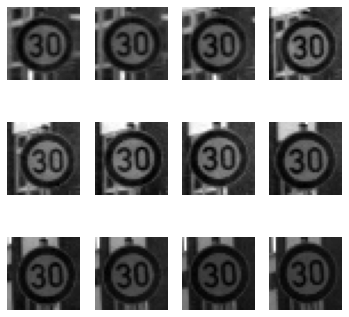

In [4]:
#samples = create_images_diag(1000)
#samples = create_images_vert(1000)
samples = load_images('signs')
samples = np.array(samples)
samples = samples/255

plt.figure(figsize=(6, 6))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(samples[i][:,:,0],cmap='gray')
    #plt.title(labels[i])
    plt.axis("off")

In [15]:
# Generator gets a noise vector of size noise_dim and generates an image of size (32 x 32 x 1)
# Our aim: we want the image to be as similar to real images (generated above) as possible
def make_generator_model():
    model = Sequential()
    model.add(Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 256)))

    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)) 
    
    #model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 8 x 8 x 128

    model.add(UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest"))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    #model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 16 x 16 x 64

    model.add(UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest"))
    model.add(Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    #model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #model.add(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # output: 32 x 32 x 1 (our image)

    model.summary()
    return model



generator = make_generator_model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)        

In [14]:
# Discriminator gets image of size (32 x 32 x 1) and decides if it is real or fake
# The result of the discriminator is used by generator to improve 'faking'

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    #model.add(Dense(1))
    # output: one number 0-fake, 1-real
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [16]:
# returns randomly choosen n samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
    new_samples = np.array(new_samples,dtype=float)    

    return new_samples

In [17]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


In [18]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

# The training step

history = []
##@tf.function
def do_step(images):
    batch_size = len(images)
    images = np.array(images)
    # create random noise for generator
    input_noise = randn(batch_size * noise_dim)
    input_noise = input_noise.reshape(batch_size, noise_dim)
    input_noise = tf.convert_to_tensor(input_noise)
    #noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator(input_noise, training=True)
        # evaluate fake images
        fake_output = discriminator(generated_images, training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator want all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        # evaluate real images
        real_output = discriminator(images, training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # step 4. calculate the gradient of the losses
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # step 5. Apply the optimizers and update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print("Epoch",epoch,'g_loss=',gen_loss.numpy(),'d_loss=',disc_loss.numpy(),"real_acc=",real_acc,"fake_acc=",fake_acc)
    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])
    

Epoch 0 g_loss= 0.68459207 d_loss= 1.3873409 real_acc= 0.64 fake_acc= 0.3


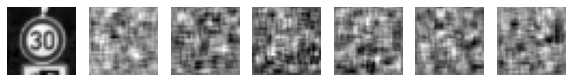

Epoch 1 g_loss= 0.7011863 d_loss= 1.3862698 real_acc= 0.48 fake_acc= 0.54
Epoch 2 g_loss= 0.72882116 d_loss= 1.3877221 real_acc= 0.18 fake_acc= 0.86
Epoch 3 g_loss= 0.7428796 d_loss= 1.3736808 real_acc= 0.06 fake_acc= 0.9
Epoch 4 g_loss= 0.7659212 d_loss= 1.3729818 real_acc= 0.04 fake_acc= 0.98
Epoch 5 g_loss= 0.7752849 d_loss= 1.3770003 real_acc= 0.0 fake_acc= 1.0
Epoch 6 g_loss= 0.8009369 d_loss= 1.3600864 real_acc= 0.0 fake_acc= 0.98
Epoch 7 g_loss= 0.7979903 d_loss= 1.3755847 real_acc= 0.04 fake_acc= 1.0
Epoch 8 g_loss= 0.8087638 d_loss= 1.3714786 real_acc= 0.02 fake_acc= 1.0
Epoch 9 g_loss= 0.8167777 d_loss= 1.3712232 real_acc= 0.0 fake_acc= 1.0
Epoch 10 g_loss= 0.81600213 d_loss= 1.3530858 real_acc= 0.04 fake_acc= 1.0


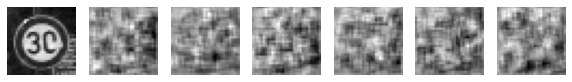

Epoch 11 g_loss= 0.805223 d_loss= 1.3403091 real_acc= 0.16 fake_acc= 1.0
Epoch 12 g_loss= 0.7966093 d_loss= 1.3541741 real_acc= 0.06 fake_acc= 1.0
Epoch 13 g_loss= 0.7892445 d_loss= 1.3666055 real_acc= 0.06 fake_acc= 1.0
Epoch 14 g_loss= 0.794233 d_loss= 1.3507042 real_acc= 0.18 fake_acc= 1.0
Epoch 15 g_loss= 0.7794358 d_loss= 1.3432696 real_acc= 0.3 fake_acc= 0.98
Epoch 16 g_loss= 0.77263033 d_loss= 1.3493323 real_acc= 0.26 fake_acc= 1.0
Epoch 17 g_loss= 0.76237124 d_loss= 1.3529193 real_acc= 0.4 fake_acc= 0.94
Epoch 18 g_loss= 0.7516495 d_loss= 1.3455052 real_acc= 0.38 fake_acc= 0.94
Epoch 19 g_loss= 0.74745226 d_loss= 1.3514442 real_acc= 0.36 fake_acc= 0.96
Epoch 20 g_loss= 0.7397257 d_loss= 1.34478 real_acc= 0.52 fake_acc= 0.88


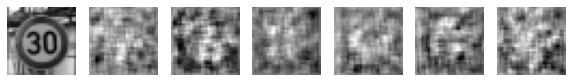

Epoch 21 g_loss= 0.73757803 d_loss= 1.3709381 real_acc= 0.48 fake_acc= 0.9
Epoch 22 g_loss= 0.7156923 d_loss= 1.365508 real_acc= 0.58 fake_acc= 0.7
Epoch 23 g_loss= 0.70976484 d_loss= 1.3685491 real_acc= 0.56 fake_acc= 0.68
Epoch 24 g_loss= 0.68796706 d_loss= 1.368023 real_acc= 0.7 fake_acc= 0.42
Epoch 25 g_loss= 0.68471503 d_loss= 1.3790119 real_acc= 0.66 fake_acc= 0.4
Epoch 26 g_loss= 0.67878306 d_loss= 1.3746164 real_acc= 0.74 fake_acc= 0.46
Epoch 27 g_loss= 0.6643363 d_loss= 1.3693497 real_acc= 0.84 fake_acc= 0.24
Epoch 28 g_loss= 0.66357565 d_loss= 1.4056327 real_acc= 0.64 fake_acc= 0.24
Epoch 29 g_loss= 0.6471684 d_loss= 1.4218853 real_acc= 0.6 fake_acc= 0.18
Epoch 30 g_loss= 0.66046274 d_loss= 1.4253623 real_acc= 0.54 fake_acc= 0.28


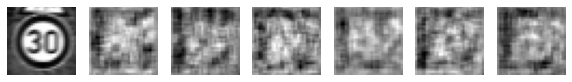

Epoch 31 g_loss= 0.6616191 d_loss= 1.4045742 real_acc= 0.68 fake_acc= 0.16
Epoch 32 g_loss= 0.6541262 d_loss= 1.4335997 real_acc= 0.52 fake_acc= 0.16
Epoch 33 g_loss= 0.6788456 d_loss= 1.4214977 real_acc= 0.38 fake_acc= 0.32
Epoch 34 g_loss= 0.6689094 d_loss= 1.4400381 real_acc= 0.36 fake_acc= 0.26
Epoch 35 g_loss= 0.67747575 d_loss= 1.4253726 real_acc= 0.42 fake_acc= 0.34
Epoch 36 g_loss= 0.7038508 d_loss= 1.407998 real_acc= 0.42 fake_acc= 0.6
Epoch 37 g_loss= 0.7073558 d_loss= 1.420696 real_acc= 0.32 fake_acc= 0.64
Epoch 38 g_loss= 0.71451545 d_loss= 1.4066842 real_acc= 0.28 fake_acc= 0.66
Epoch 39 g_loss= 0.72247666 d_loss= 1.3967574 real_acc= 0.3 fake_acc= 0.72
Epoch 40 g_loss= 0.74303275 d_loss= 1.3941908 real_acc= 0.32 fake_acc= 0.92


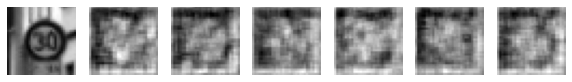

Epoch 41 g_loss= 0.76752526 d_loss= 1.3770342 real_acc= 0.28 fake_acc= 0.92
Epoch 42 g_loss= 0.7647116 d_loss= 1.3737581 real_acc= 0.32 fake_acc= 0.94
Epoch 43 g_loss= 0.78910506 d_loss= 1.3400407 real_acc= 0.32 fake_acc= 0.98
Epoch 44 g_loss= 0.8053405 d_loss= 1.3290668 real_acc= 0.34 fake_acc= 1.0
Epoch 45 g_loss= 0.8143433 d_loss= 1.3181245 real_acc= 0.38 fake_acc= 1.0
Epoch 46 g_loss= 0.83672065 d_loss= 1.3375401 real_acc= 0.18 fake_acc= 1.0
Epoch 47 g_loss= 0.8628521 d_loss= 1.2887386 real_acc= 0.32 fake_acc= 1.0
Epoch 48 g_loss= 0.870254 d_loss= 1.2493836 real_acc= 0.5 fake_acc= 1.0
Epoch 49 g_loss= 0.88884413 d_loss= 1.2454218 real_acc= 0.38 fake_acc= 1.0
Epoch 50 g_loss= 0.9000424 d_loss= 1.2051344 real_acc= 0.56 fake_acc= 1.0


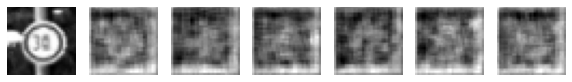

Epoch 51 g_loss= 0.9235782 d_loss= 1.1771494 real_acc= 0.66 fake_acc= 1.0
Epoch 52 g_loss= 0.92215383 d_loss= 1.1978798 real_acc= 0.54 fake_acc= 1.0
Epoch 53 g_loss= 0.92429674 d_loss= 1.1635416 real_acc= 0.68 fake_acc= 1.0
Epoch 54 g_loss= 0.95659417 d_loss= 1.1284518 real_acc= 0.76 fake_acc= 1.0
Epoch 55 g_loss= 0.9401013 d_loss= 1.0912763 real_acc= 0.9 fake_acc= 1.0
Epoch 56 g_loss= 0.93479365 d_loss= 1.0965159 real_acc= 0.82 fake_acc= 1.0
Epoch 57 g_loss= 0.9211668 d_loss= 1.094509 real_acc= 0.84 fake_acc= 1.0
Epoch 58 g_loss= 0.901561 d_loss= 1.1049349 real_acc= 0.92 fake_acc= 1.0
Epoch 59 g_loss= 0.87221354 d_loss= 1.0962392 real_acc= 0.96 fake_acc= 1.0
Epoch 60 g_loss= 0.8409443 d_loss= 1.1267352 real_acc= 0.9 fake_acc= 0.98


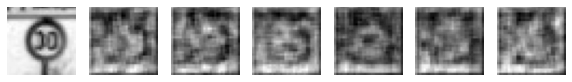

Epoch 61 g_loss= 0.7947818 d_loss= 1.1231637 real_acc= 0.96 fake_acc= 0.92
Epoch 62 g_loss= 0.76038796 d_loss= 1.1752692 real_acc= 0.92 fake_acc= 0.84
Epoch 63 g_loss= 0.69247085 d_loss= 1.2171462 real_acc= 0.92 fake_acc= 0.48
Epoch 64 g_loss= 0.64014184 d_loss= 1.2624974 real_acc= 0.96 fake_acc= 0.28
Epoch 65 g_loss= 0.62048244 d_loss= 1.3271754 real_acc= 0.86 fake_acc= 0.12
Epoch 66 g_loss= 0.5792482 d_loss= 1.3358674 real_acc= 0.94 fake_acc= 0.04
Epoch 67 g_loss= 0.5338224 d_loss= 1.4300413 real_acc= 0.9 fake_acc= 0.02
Epoch 68 g_loss= 0.524755 d_loss= 1.5020306 real_acc= 0.7 fake_acc= 0.04
Epoch 69 g_loss= 0.49776286 d_loss= 1.5732715 real_acc= 0.7 fake_acc= 0.0
Epoch 70 g_loss= 0.4708541 d_loss= 1.5993229 real_acc= 0.68 fake_acc= 0.0


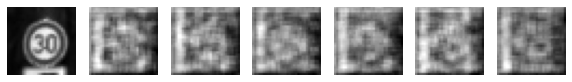

Epoch 71 g_loss= 0.44911206 d_loss= 1.637442 real_acc= 0.72 fake_acc= 0.0
Epoch 72 g_loss= 0.4423625 d_loss= 1.7335205 real_acc= 0.6 fake_acc= 0.0
Epoch 73 g_loss= 0.43994704 d_loss= 1.849374 real_acc= 0.34 fake_acc= 0.0
Epoch 74 g_loss= 0.4278608 d_loss= 1.8691131 real_acc= 0.4 fake_acc= 0.0
Epoch 75 g_loss= 0.42709818 d_loss= 1.9523067 real_acc= 0.28 fake_acc= 0.0
Epoch 76 g_loss= 0.4117752 d_loss= 1.9717002 real_acc= 0.2 fake_acc= 0.0
Epoch 77 g_loss= 0.41791818 d_loss= 1.9889574 real_acc= 0.16 fake_acc= 0.0
Epoch 78 g_loss= 0.4281848 d_loss= 2.0244894 real_acc= 0.16 fake_acc= 0.0
Epoch 79 g_loss= 0.43763965 d_loss= 1.9892951 real_acc= 0.06 fake_acc= 0.0
Epoch 80 g_loss= 0.45651996 d_loss= 1.958514 real_acc= 0.12 fake_acc= 0.0


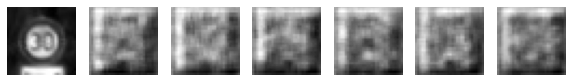

Epoch 81 g_loss= 0.45887494 d_loss= 1.923284 real_acc= 0.12 fake_acc= 0.02
Epoch 82 g_loss= 0.4732201 d_loss= 1.9295175 real_acc= 0.12 fake_acc= 0.0
Epoch 83 g_loss= 0.4947224 d_loss= 1.9181969 real_acc= 0.02 fake_acc= 0.0
Epoch 84 g_loss= 0.5210239 d_loss= 1.912973 real_acc= 0.04 fake_acc= 0.02
Epoch 85 g_loss= 0.5453569 d_loss= 1.8765517 real_acc= 0.04 fake_acc= 0.0
Epoch 86 g_loss= 0.5621409 d_loss= 1.8252065 real_acc= 0.04 fake_acc= 0.04
Epoch 87 g_loss= 0.58632636 d_loss= 1.7725024 real_acc= 0.0 fake_acc= 0.04
Epoch 88 g_loss= 0.60060436 d_loss= 1.7510548 real_acc= 0.06 fake_acc= 0.06
Epoch 89 g_loss= 0.6169689 d_loss= 1.7106754 real_acc= 0.04 fake_acc= 0.08
Epoch 90 g_loss= 0.6364691 d_loss= 1.6212192 real_acc= 0.04 fake_acc= 0.12


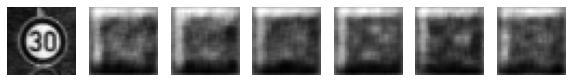

Epoch 91 g_loss= 0.64072114 d_loss= 1.5920823 real_acc= 0.1 fake_acc= 0.08
Epoch 92 g_loss= 0.63971 d_loss= 1.5960233 real_acc= 0.14 fake_acc= 0.1
Epoch 93 g_loss= 0.64882517 d_loss= 1.5767404 real_acc= 0.04 fake_acc= 0.2
Epoch 94 g_loss= 0.6541822 d_loss= 1.5357287 real_acc= 0.14 fake_acc= 0.2
Epoch 95 g_loss= 0.6508374 d_loss= 1.505758 real_acc= 0.2 fake_acc= 0.12
Epoch 96 g_loss= 0.66542906 d_loss= 1.4944838 real_acc= 0.28 fake_acc= 0.28
Epoch 97 g_loss= 0.6830023 d_loss= 1.4342786 real_acc= 0.42 fake_acc= 0.42
Epoch 98 g_loss= 0.6781899 d_loss= 1.4257674 real_acc= 0.42 fake_acc= 0.3
Epoch 99 g_loss= 0.6842048 d_loss= 1.4285722 real_acc= 0.32 fake_acc= 0.4
Epoch 100 g_loss= 0.68475235 d_loss= 1.3853147 real_acc= 0.52 fake_acc= 0.38


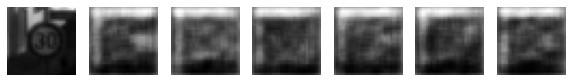

Epoch 101 g_loss= 0.6892744 d_loss= 1.3813417 real_acc= 0.56 fake_acc= 0.38
Epoch 102 g_loss= 0.6890585 d_loss= 1.3749375 real_acc= 0.6 fake_acc= 0.44
Epoch 103 g_loss= 0.686336 d_loss= 1.3775915 real_acc= 0.62 fake_acc= 0.44
Epoch 104 g_loss= 0.68126816 d_loss= 1.3371447 real_acc= 0.88 fake_acc= 0.42
Epoch 105 g_loss= 0.6847504 d_loss= 1.343426 real_acc= 0.86 fake_acc= 0.4
Epoch 106 g_loss= 0.676524 d_loss= 1.3349988 real_acc= 0.8 fake_acc= 0.42
Epoch 107 g_loss= 0.6742212 d_loss= 1.3392282 real_acc= 0.86 fake_acc= 0.36
Epoch 108 g_loss= 0.6632634 d_loss= 1.3389345 real_acc= 0.86 fake_acc= 0.24
Epoch 109 g_loss= 0.6561154 d_loss= 1.337107 real_acc= 0.86 fake_acc= 0.18
Epoch 110 g_loss= 0.64792657 d_loss= 1.3270543 real_acc= 0.94 fake_acc= 0.2


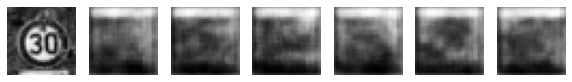

Epoch 111 g_loss= 0.6468495 d_loss= 1.3220563 real_acc= 0.98 fake_acc= 0.14
Epoch 112 g_loss= 0.6396518 d_loss= 1.3332283 real_acc= 0.94 fake_acc= 0.16
Epoch 113 g_loss= 0.64135706 d_loss= 1.3390307 real_acc= 0.86 fake_acc= 0.1
Epoch 114 g_loss= 0.64867693 d_loss= 1.3441212 real_acc= 0.84 fake_acc= 0.2
Epoch 115 g_loss= 0.64586973 d_loss= 1.326966 real_acc= 0.86 fake_acc= 0.16
Epoch 116 g_loss= 0.64296705 d_loss= 1.3001671 real_acc= 0.94 fake_acc= 0.18
Epoch 117 g_loss= 0.6607568 d_loss= 1.3130857 real_acc= 0.92 fake_acc= 0.28
Epoch 118 g_loss= 0.66042066 d_loss= 1.3124219 real_acc= 0.9 fake_acc= 0.26
Epoch 119 g_loss= 0.6860131 d_loss= 1.2732526 real_acc= 0.94 fake_acc= 0.42
Epoch 120 g_loss= 0.6943924 d_loss= 1.2390393 real_acc= 0.96 fake_acc= 0.56


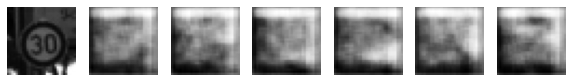

Epoch 121 g_loss= 0.7140912 d_loss= 1.256298 real_acc= 0.9 fake_acc= 0.64
Epoch 122 g_loss= 0.73551553 d_loss= 1.230278 real_acc= 0.96 fake_acc= 0.68
Epoch 123 g_loss= 0.7538048 d_loss= 1.204623 real_acc= 0.94 fake_acc= 0.78
Epoch 124 g_loss= 0.7751563 d_loss= 1.210141 real_acc= 0.9 fake_acc= 0.88
Epoch 125 g_loss= 0.79526544 d_loss= 1.1949747 real_acc= 0.88 fake_acc= 0.94
Epoch 126 g_loss= 0.8339606 d_loss= 1.1303163 real_acc= 1.0 fake_acc= 0.94
Epoch 127 g_loss= 0.8548932 d_loss= 1.1798 real_acc= 0.78 fake_acc= 0.94
Epoch 128 g_loss= 0.88728 d_loss= 1.137422 real_acc= 0.8 fake_acc= 0.94
Epoch 129 g_loss= 0.9145437 d_loss= 1.1392665 real_acc= 0.86 fake_acc= 1.0
Epoch 130 g_loss= 0.9583477 d_loss= 1.1048003 real_acc= 0.78 fake_acc= 1.0


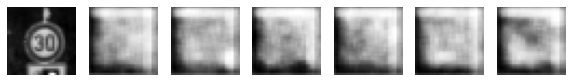

Epoch 131 g_loss= 1.0024579 d_loss= 1.076221 real_acc= 0.8 fake_acc= 1.0
Epoch 132 g_loss= 1.0424504 d_loss= 1.0858475 real_acc= 0.7 fake_acc= 1.0
Epoch 133 g_loss= 1.0490983 d_loss= 1.0615741 real_acc= 0.78 fake_acc= 1.0
Epoch 134 g_loss= 1.0824742 d_loss= 1.0383527 real_acc= 0.86 fake_acc= 1.0
Epoch 135 g_loss= 1.1095115 d_loss= 1.0585946 real_acc= 0.72 fake_acc= 1.0
Epoch 136 g_loss= 1.1549822 d_loss= 1.0269539 real_acc= 0.78 fake_acc= 1.0
Epoch 137 g_loss= 1.1415807 d_loss= 1.0521833 real_acc= 0.68 fake_acc= 1.0
Epoch 138 g_loss= 1.1901193 d_loss= 0.9998295 real_acc= 0.8 fake_acc= 1.0
Epoch 139 g_loss= 1.2384557 d_loss= 0.96612 real_acc= 0.78 fake_acc= 1.0
Epoch 140 g_loss= 1.2133334 d_loss= 1.0133134 real_acc= 0.66 fake_acc= 1.0


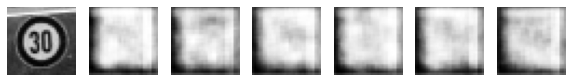

Epoch 141 g_loss= 1.2017237 d_loss= 0.9912385 real_acc= 0.74 fake_acc= 1.0
Epoch 142 g_loss= 1.2073724 d_loss= 0.99469006 real_acc= 0.76 fake_acc= 1.0
Epoch 143 g_loss= 1.1536871 d_loss= 1.0305097 real_acc= 0.66 fake_acc= 1.0
Epoch 144 g_loss= 1.1228662 d_loss= 1.0445284 real_acc= 0.72 fake_acc= 0.96
Epoch 145 g_loss= 1.1353782 d_loss= 1.0426209 real_acc= 0.76 fake_acc= 0.96
Epoch 146 g_loss= 1.1576223 d_loss= 1.0172426 real_acc= 0.64 fake_acc= 1.0
Epoch 147 g_loss= 1.1633239 d_loss= 1.0140529 real_acc= 0.74 fake_acc= 0.98
Epoch 148 g_loss= 1.1218342 d_loss= 1.013378 real_acc= 0.9 fake_acc= 0.94
Epoch 149 g_loss= 1.1842293 d_loss= 1.0864402 real_acc= 0.58 fake_acc= 0.9
Epoch 150 g_loss= 1.16721 d_loss= 1.0600913 real_acc= 0.64 fake_acc= 0.88


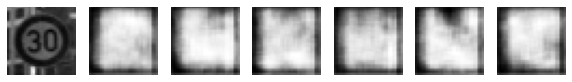

Epoch 151 g_loss= 1.1607512 d_loss= 1.1437082 real_acc= 0.46 fake_acc= 0.98
Epoch 152 g_loss= 1.1405473 d_loss= 1.0676386 real_acc= 0.62 fake_acc= 0.92
Epoch 153 g_loss= 1.1397545 d_loss= 1.1218828 real_acc= 0.6 fake_acc= 0.9
Epoch 154 g_loss= 1.119342 d_loss= 1.1544487 real_acc= 0.56 fake_acc= 0.86
Epoch 155 g_loss= 1.0650228 d_loss= 1.2568681 real_acc= 0.26 fake_acc= 0.86
Epoch 156 g_loss= 1.0181639 d_loss= 1.2448691 real_acc= 0.48 fake_acc= 0.84
Epoch 157 g_loss= 0.9231382 d_loss= 1.2797253 real_acc= 0.56 fake_acc= 0.72
Epoch 158 g_loss= 0.92171586 d_loss= 1.3312695 real_acc= 0.48 fake_acc= 0.68
Epoch 159 g_loss= 0.85883147 d_loss= 1.4441383 real_acc= 0.26 fake_acc= 0.68
Epoch 160 g_loss= 0.82720244 d_loss= 1.5346489 real_acc= 0.26 fake_acc= 0.6


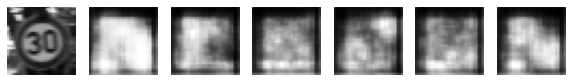

Epoch 161 g_loss= 0.75404197 d_loss= 1.4853795 real_acc= 0.44 fake_acc= 0.44
Epoch 162 g_loss= 0.6820301 d_loss= 1.5877204 real_acc= 0.44 fake_acc= 0.4
Epoch 163 g_loss= 0.6529718 d_loss= 1.7050953 real_acc= 0.24 fake_acc= 0.46
Epoch 164 g_loss= 0.7101906 d_loss= 1.7059879 real_acc= 0.24 fake_acc= 0.46
Epoch 165 g_loss= 0.67292005 d_loss= 1.8181331 real_acc= 0.24 fake_acc= 0.44
Epoch 166 g_loss= 0.6737527 d_loss= 1.9093597 real_acc= 0.18 fake_acc= 0.36
Epoch 167 g_loss= 0.58671576 d_loss= 1.9843407 real_acc= 0.1 fake_acc= 0.26
Epoch 168 g_loss= 0.61508673 d_loss= 1.9420785 real_acc= 0.1 fake_acc= 0.34
Epoch 169 g_loss= 0.6148989 d_loss= 2.0063777 real_acc= 0.08 fake_acc= 0.34
Epoch 170 g_loss= 0.6565606 d_loss= 2.2553911 real_acc= 0.04 fake_acc= 0.42


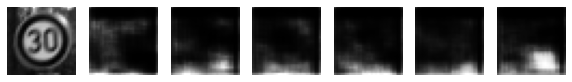

Epoch 171 g_loss= 0.6480217 d_loss= 2.2467504 real_acc= 0.0 fake_acc= 0.32
Epoch 172 g_loss= 0.64488757 d_loss= 2.1840084 real_acc= 0.0 fake_acc= 0.36
Epoch 173 g_loss= 0.6464819 d_loss= 2.140428 real_acc= 0.04 fake_acc= 0.32
Epoch 174 g_loss= 0.6401166 d_loss= 2.0878258 real_acc= 0.06 fake_acc= 0.38
Epoch 175 g_loss= 0.686263 d_loss= 2.1380606 real_acc= 0.04 fake_acc= 0.38
Epoch 176 g_loss= 0.6685669 d_loss= 1.9760959 real_acc= 0.02 fake_acc= 0.4
Epoch 177 g_loss= 0.66383874 d_loss= 2.0448103 real_acc= 0.0 fake_acc= 0.36
Epoch 178 g_loss= 0.6683219 d_loss= 2.0034277 real_acc= 0.06 fake_acc= 0.34
Epoch 179 g_loss= 0.685925 d_loss= 1.8936038 real_acc= 0.04 fake_acc= 0.42
Epoch 180 g_loss= 0.67252696 d_loss= 2.0190287 real_acc= 0.02 fake_acc= 0.42


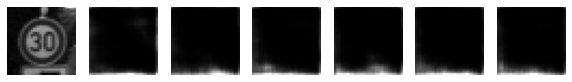

Epoch 181 g_loss= 0.69900656 d_loss= 1.848275 real_acc= 0.04 fake_acc= 0.44
Epoch 182 g_loss= 0.69432074 d_loss= 1.8383757 real_acc= 0.04 fake_acc= 0.44
Epoch 183 g_loss= 0.68016785 d_loss= 1.8041487 real_acc= 0.06 fake_acc= 0.46
Epoch 184 g_loss= 0.71448725 d_loss= 1.6882744 real_acc= 0.12 fake_acc= 0.6
Epoch 185 g_loss= 0.72340465 d_loss= 1.6647494 real_acc= 0.06 fake_acc= 0.56
Epoch 186 g_loss= 0.73181605 d_loss= 1.5750268 real_acc= 0.14 fake_acc= 0.6
Epoch 187 g_loss= 0.75004256 d_loss= 1.5490817 real_acc= 0.14 fake_acc= 0.64
Epoch 188 g_loss= 0.7691114 d_loss= 1.5017773 real_acc= 0.16 fake_acc= 0.7
Epoch 189 g_loss= 0.77742577 d_loss= 1.3998296 real_acc= 0.3 fake_acc= 0.68
Epoch 190 g_loss= 0.80190665 d_loss= 1.4156387 real_acc= 0.22 fake_acc= 0.82


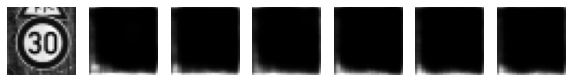

Epoch 191 g_loss= 0.81628954 d_loss= 1.376151 real_acc= 0.24 fake_acc= 0.84
Epoch 192 g_loss= 0.832081 d_loss= 1.3094649 real_acc= 0.44 fake_acc= 0.9
Epoch 193 g_loss= 0.8486191 d_loss= 1.2721959 real_acc= 0.52 fake_acc= 0.96
Epoch 194 g_loss= 0.87388414 d_loss= 1.2183807 real_acc= 0.68 fake_acc= 0.92
Epoch 195 g_loss= 0.90300775 d_loss= 1.199935 real_acc= 0.64 fake_acc= 0.94
Epoch 196 g_loss= 0.93382293 d_loss= 1.1550691 real_acc= 0.8 fake_acc= 1.0
Epoch 197 g_loss= 0.93792313 d_loss= 1.155862 real_acc= 0.74 fake_acc= 0.98
Epoch 198 g_loss= 0.9551711 d_loss= 1.0964377 real_acc= 0.86 fake_acc= 0.98
Epoch 199 g_loss= 0.9663937 d_loss= 1.0910465 real_acc= 0.86 fake_acc= 0.98
Epoch 200 g_loss= 0.9553226 d_loss= 1.0921538 real_acc= 0.9 fake_acc= 0.98


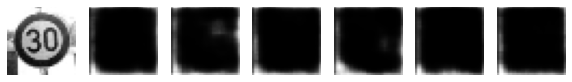

Epoch 201 g_loss= 0.99418235 d_loss= 1.065201 real_acc= 0.76 fake_acc= 1.0
Epoch 202 g_loss= 1.0010237 d_loss= 1.0586808 real_acc= 0.9 fake_acc= 1.0
Epoch 203 g_loss= 1.0189964 d_loss= 0.99878144 real_acc= 0.92 fake_acc= 1.0
Epoch 204 g_loss= 0.9985679 d_loss= 1.0268215 real_acc= 0.98 fake_acc= 0.96
Epoch 205 g_loss= 1.0151439 d_loss= 1.0136979 real_acc= 0.88 fake_acc= 0.98
Epoch 206 g_loss= 1.0243506 d_loss= 1.0113444 real_acc= 0.92 fake_acc= 0.98
Epoch 207 g_loss= 1.0296412 d_loss= 0.9917306 real_acc= 0.92 fake_acc= 1.0
Epoch 208 g_loss= 1.0201159 d_loss= 1.0031796 real_acc= 0.9 fake_acc= 0.98
Epoch 209 g_loss= 0.9670031 d_loss= 1.0006794 real_acc= 0.92 fake_acc= 0.92
Epoch 210 g_loss= 0.977671 d_loss= 0.9864919 real_acc= 0.94 fake_acc= 0.92


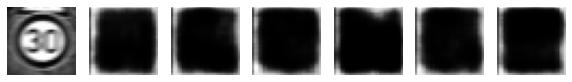

Epoch 211 g_loss= 0.9622637 d_loss= 1.0496994 real_acc= 0.84 fake_acc= 0.88
Epoch 212 g_loss= 0.9188355 d_loss= 1.0144583 real_acc= 0.94 fake_acc= 0.88
Epoch 213 g_loss= 0.89282244 d_loss= 1.0579238 real_acc= 0.94 fake_acc= 0.88
Epoch 214 g_loss= 0.90433764 d_loss= 1.0824603 real_acc= 0.84 fake_acc= 0.86
Epoch 215 g_loss= 0.8622875 d_loss= 1.0814885 real_acc= 0.92 fake_acc= 0.8
Epoch 216 g_loss= 0.82158303 d_loss= 1.1037657 real_acc= 0.86 fake_acc= 0.76
Epoch 217 g_loss= 0.8326553 d_loss= 1.1573744 real_acc= 0.76 fake_acc= 0.72
Epoch 218 g_loss= 0.8240105 d_loss= 1.1473781 real_acc= 0.9 fake_acc= 0.76
Epoch 219 g_loss= 0.84238684 d_loss= 1.1344719 real_acc= 0.76 fake_acc= 0.7
Epoch 220 g_loss= 0.81600875 d_loss= 1.121614 real_acc= 0.84 fake_acc= 0.8


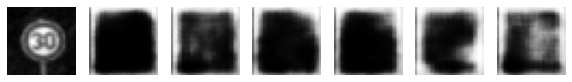

Epoch 221 g_loss= 0.80901986 d_loss= 1.1824584 real_acc= 0.8 fake_acc= 0.7
Epoch 222 g_loss= 0.8119251 d_loss= 1.1304522 real_acc= 0.84 fake_acc= 0.7
Epoch 223 g_loss= 0.8418699 d_loss= 1.1304703 real_acc= 0.78 fake_acc= 0.82
Epoch 224 g_loss= 0.89666283 d_loss= 1.1142483 real_acc= 0.74 fake_acc= 0.8
Epoch 225 g_loss= 0.8236825 d_loss= 1.1696224 real_acc= 0.7 fake_acc= 0.72
Epoch 226 g_loss= 0.8841229 d_loss= 1.2636075 real_acc= 0.6 fake_acc= 0.74
Epoch 227 g_loss= 0.929564 d_loss= 1.2211704 real_acc= 0.64 fake_acc= 0.72
Epoch 228 g_loss= 0.8999646 d_loss= 1.2270083 real_acc= 0.62 fake_acc= 0.78
Epoch 229 g_loss= 0.98398775 d_loss= 1.2380418 real_acc= 0.54 fake_acc= 0.78
Epoch 230 g_loss= 0.96043533 d_loss= 1.226489 real_acc= 0.6 fake_acc= 0.74


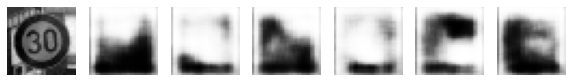

Epoch 231 g_loss= 0.9481163 d_loss= 1.2328764 real_acc= 0.62 fake_acc= 0.7
Epoch 232 g_loss= 1.0363804 d_loss= 1.159357 real_acc= 0.6 fake_acc= 0.86
Epoch 233 g_loss= 1.018703 d_loss= 1.1997064 real_acc= 0.52 fake_acc= 0.78
Epoch 234 g_loss= 1.0463581 d_loss= 1.2076737 real_acc= 0.58 fake_acc= 0.84
Epoch 235 g_loss= 1.1372191 d_loss= 1.3188896 real_acc= 0.4 fake_acc= 0.98
Epoch 236 g_loss= 1.1290355 d_loss= 1.1717823 real_acc= 0.5 fake_acc= 0.88
Epoch 237 g_loss= 1.1490405 d_loss= 1.2080302 real_acc= 0.48 fake_acc= 0.92
Epoch 238 g_loss= 1.1162745 d_loss= 1.2818763 real_acc= 0.5 fake_acc= 0.92
Epoch 239 g_loss= 1.1259484 d_loss= 1.1419998 real_acc= 0.64 fake_acc= 0.94
Epoch 240 g_loss= 1.1500875 d_loss= 1.14517 real_acc= 0.6 fake_acc= 0.94


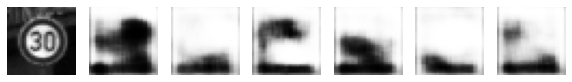

Epoch 241 g_loss= 1.1151246 d_loss= 1.1724697 real_acc= 0.58 fake_acc= 0.88
Epoch 242 g_loss= 1.0822786 d_loss= 1.2257328 real_acc= 0.52 fake_acc= 0.86
Epoch 243 g_loss= 1.1543441 d_loss= 1.2602146 real_acc= 0.52 fake_acc= 0.86
Epoch 244 g_loss= 1.1148055 d_loss= 1.1469965 real_acc= 0.54 fake_acc= 0.9
Epoch 245 g_loss= 1.0262344 d_loss= 1.3053262 real_acc= 0.6 fake_acc= 0.8
Epoch 246 g_loss= 1.0639056 d_loss= 1.1404291 real_acc= 0.6 fake_acc= 0.9
Epoch 247 g_loss= 1.0386455 d_loss= 1.2591819 real_acc= 0.56 fake_acc= 0.88
Epoch 248 g_loss= 0.9854246 d_loss= 1.2453592 real_acc= 0.56 fake_acc= 0.76
Epoch 249 g_loss= 0.9683216 d_loss= 1.2437649 real_acc= 0.64 fake_acc= 0.72
Epoch 250 g_loss= 1.0089575 d_loss= 1.1011062 real_acc= 0.68 fake_acc= 0.76


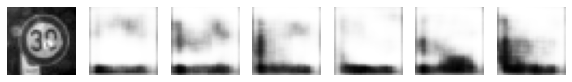

Epoch 251 g_loss= 0.98361725 d_loss= 1.2131288 real_acc= 0.62 fake_acc= 0.68
Epoch 252 g_loss= 1.0160311 d_loss= 1.3267982 real_acc= 0.54 fake_acc= 0.86
Epoch 253 g_loss= 1.0109593 d_loss= 1.3278922 real_acc= 0.54 fake_acc= 0.82
Epoch 254 g_loss= 0.9862461 d_loss= 1.232641 real_acc= 0.66 fake_acc= 0.86
Epoch 255 g_loss= 1.0202192 d_loss= 1.2172538 real_acc= 0.66 fake_acc= 0.76
Epoch 256 g_loss= 0.9901406 d_loss= 1.2310708 real_acc= 0.62 fake_acc= 0.72
Epoch 257 g_loss= 1.048401 d_loss= 1.2518766 real_acc= 0.64 fake_acc= 0.78
Epoch 258 g_loss= 1.0187919 d_loss= 1.2975364 real_acc= 0.46 fake_acc= 0.82
Epoch 259 g_loss= 0.99836737 d_loss= 1.475219 real_acc= 0.44 fake_acc= 0.72
Epoch 260 g_loss= 1.0330273 d_loss= 1.2103255 real_acc= 0.56 fake_acc= 0.82


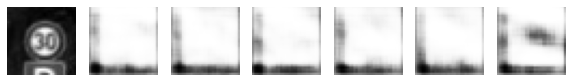

Epoch 261 g_loss= 0.9817026 d_loss= 1.4191283 real_acc= 0.54 fake_acc= 0.74
Epoch 262 g_loss= 0.989829 d_loss= 1.2361455 real_acc= 0.6 fake_acc= 0.86
Epoch 263 g_loss= 0.9767366 d_loss= 1.3236256 real_acc= 0.48 fake_acc= 0.82
Epoch 264 g_loss= 1.0026344 d_loss= 1.272145 real_acc= 0.54 fake_acc= 0.7
Epoch 265 g_loss= 0.9623925 d_loss= 1.1666336 real_acc= 0.7 fake_acc= 0.68
Epoch 266 g_loss= 0.9225379 d_loss= 1.247009 real_acc= 0.7 fake_acc= 0.66
Epoch 267 g_loss= 0.9572313 d_loss= 1.2314384 real_acc= 0.66 fake_acc= 0.7
Epoch 268 g_loss= 1.0200467 d_loss= 1.1923038 real_acc= 0.62 fake_acc= 0.82
Epoch 269 g_loss= 1.0900571 d_loss= 1.2961048 real_acc= 0.54 fake_acc= 0.82
Epoch 270 g_loss= 1.0399677 d_loss= 1.2304147 real_acc= 0.52 fake_acc= 0.74


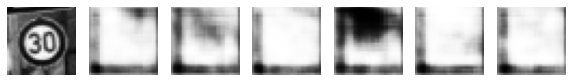

Epoch 271 g_loss= 1.0355829 d_loss= 1.1593802 real_acc= 0.66 fake_acc= 0.74
Epoch 272 g_loss= 1.0560429 d_loss= 1.2070444 real_acc= 0.6 fake_acc= 0.82
Epoch 273 g_loss= 1.0000459 d_loss= 1.2655053 real_acc= 0.54 fake_acc= 0.74
Epoch 274 g_loss= 1.0183436 d_loss= 1.2093415 real_acc= 0.64 fake_acc= 0.74
Epoch 275 g_loss= 1.0318929 d_loss= 1.2688681 real_acc= 0.56 fake_acc= 0.8
Epoch 276 g_loss= 1.0395538 d_loss= 1.1632217 real_acc= 0.64 fake_acc= 0.9
Epoch 277 g_loss= 1.061662 d_loss= 1.1677 real_acc= 0.66 fake_acc= 0.9
Epoch 278 g_loss= 0.99925584 d_loss= 1.1529076 real_acc= 0.7 fake_acc= 0.78
Epoch 279 g_loss= 0.9698598 d_loss= 1.1929407 real_acc= 0.62 fake_acc= 0.82
Epoch 280 g_loss= 0.99045175 d_loss= 1.1683756 real_acc= 0.62 fake_acc= 0.8


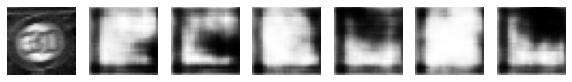

Epoch 281 g_loss= 0.9077029 d_loss= 1.2345498 real_acc= 0.68 fake_acc= 0.72
Epoch 282 g_loss= 0.9324112 d_loss= 1.1937187 real_acc= 0.66 fake_acc= 0.78
Epoch 283 g_loss= 0.8896381 d_loss= 1.2155228 real_acc= 0.68 fake_acc= 0.76
Epoch 284 g_loss= 0.84680945 d_loss= 1.282007 real_acc= 0.58 fake_acc= 0.72
Epoch 285 g_loss= 0.83501303 d_loss= 1.2809918 real_acc= 0.64 fake_acc= 0.66
Epoch 286 g_loss= 0.7858307 d_loss= 1.3160328 real_acc= 0.58 fake_acc= 0.66
Epoch 287 g_loss= 0.7627067 d_loss= 1.3209004 real_acc= 0.72 fake_acc= 0.64
Epoch 288 g_loss= 0.7550395 d_loss= 1.3123399 real_acc= 0.7 fake_acc= 0.56
Epoch 289 g_loss= 0.7219217 d_loss= 1.3753994 real_acc= 0.58 fake_acc= 0.52
Epoch 290 g_loss= 0.72586805 d_loss= 1.3939838 real_acc= 0.62 fake_acc= 0.46


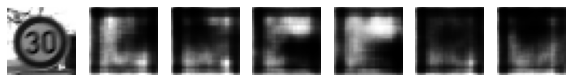

Epoch 291 g_loss= 0.7000824 d_loss= 1.4869566 real_acc= 0.5 fake_acc= 0.38
Epoch 292 g_loss= 0.75494367 d_loss= 1.4465446 real_acc= 0.54 fake_acc= 0.56
Epoch 293 g_loss= 0.7254753 d_loss= 1.480638 real_acc= 0.44 fake_acc= 0.5
Epoch 294 g_loss= 0.7437944 d_loss= 1.5620866 real_acc= 0.48 fake_acc= 0.52
Epoch 295 g_loss= 0.7349063 d_loss= 1.5643247 real_acc= 0.34 fake_acc= 0.62
Epoch 296 g_loss= 0.7286438 d_loss= 1.6397966 real_acc= 0.32 fake_acc= 0.54
Epoch 297 g_loss= 0.7612928 d_loss= 1.5618811 real_acc= 0.24 fake_acc= 0.62
Epoch 298 g_loss= 0.75819623 d_loss= 1.684572 real_acc= 0.22 fake_acc= 0.6
Epoch 299 g_loss= 0.7562169 d_loss= 1.5255277 real_acc= 0.36 fake_acc= 0.54
Epoch 300 g_loss= 0.7654517 d_loss= 1.5580564 real_acc= 0.34 fake_acc= 0.56


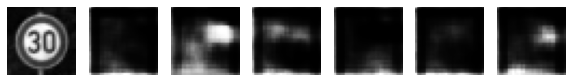

Epoch 301 g_loss= 0.78431296 d_loss= 1.4807866 real_acc= 0.32 fake_acc= 0.6
Epoch 302 g_loss= 0.7496807 d_loss= 1.6235149 real_acc= 0.28 fake_acc= 0.52
Epoch 303 g_loss= 0.75384974 d_loss= 1.6070027 real_acc= 0.3 fake_acc= 0.54
Epoch 304 g_loss= 0.7346045 d_loss= 1.4816481 real_acc= 0.4 fake_acc= 0.5
Epoch 305 g_loss= 0.7400998 d_loss= 1.4447305 real_acc= 0.5 fake_acc= 0.54
Epoch 306 g_loss= 0.73991865 d_loss= 1.3808289 real_acc= 0.52 fake_acc= 0.54
Epoch 307 g_loss= 0.7281341 d_loss= 1.4089875 real_acc= 0.54 fake_acc= 0.46
Epoch 308 g_loss= 0.7173761 d_loss= 1.3980429 real_acc= 0.56 fake_acc= 0.5
Epoch 309 g_loss= 0.7699237 d_loss= 1.4203614 real_acc= 0.48 fake_acc= 0.66
Epoch 310 g_loss= 0.74404556 d_loss= 1.4333278 real_acc= 0.46 fake_acc= 0.64


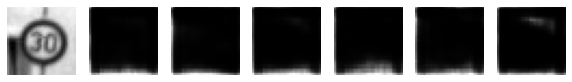

Epoch 311 g_loss= 0.77595747 d_loss= 1.350481 real_acc= 0.58 fake_acc= 0.62
Epoch 312 g_loss= 0.77949905 d_loss= 1.3057209 real_acc= 0.64 fake_acc= 0.7
Epoch 313 g_loss= 0.7972523 d_loss= 1.262052 real_acc= 0.64 fake_acc= 0.8
Epoch 314 g_loss= 0.82332605 d_loss= 1.3022268 real_acc= 0.58 fake_acc= 0.86
Epoch 315 g_loss= 0.83685905 d_loss= 1.1628771 real_acc= 0.8 fake_acc= 0.84
Epoch 316 g_loss= 0.8750428 d_loss= 1.1742537 real_acc= 0.64 fake_acc= 0.92
Epoch 317 g_loss= 0.912117 d_loss= 1.1742582 real_acc= 0.64 fake_acc= 1.0
Epoch 318 g_loss= 0.91348994 d_loss= 1.1485406 real_acc= 0.68 fake_acc= 0.98
Epoch 319 g_loss= 0.9448639 d_loss= 1.101043 real_acc= 0.74 fake_acc= 1.0
Epoch 320 g_loss= 0.96684515 d_loss= 1.0961758 real_acc= 0.76 fake_acc= 1.0


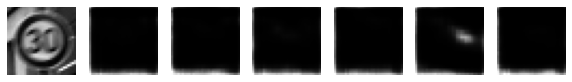

Epoch 321 g_loss= 1.016657 d_loss= 1.0484225 real_acc= 0.84 fake_acc= 1.0
Epoch 322 g_loss= 1.0429341 d_loss= 1.0025082 real_acc= 0.84 fake_acc= 1.0
Epoch 323 g_loss= 1.1015221 d_loss= 0.9637618 real_acc= 0.84 fake_acc= 1.0
Epoch 324 g_loss= 1.107629 d_loss= 0.96347207 real_acc= 0.76 fake_acc= 1.0
Epoch 325 g_loss= 1.1325197 d_loss= 0.9777309 real_acc= 0.76 fake_acc= 1.0
Epoch 326 g_loss= 1.1676621 d_loss= 0.89524883 real_acc= 0.86 fake_acc= 1.0
Epoch 327 g_loss= 1.178139 d_loss= 0.88100857 real_acc= 0.84 fake_acc= 1.0
Epoch 328 g_loss= 1.1798408 d_loss= 0.8457042 real_acc= 0.94 fake_acc= 1.0
Epoch 329 g_loss= 1.2458893 d_loss= 0.8331541 real_acc= 0.9 fake_acc= 1.0
Epoch 330 g_loss= 1.2441437 d_loss= 0.83067614 real_acc= 0.92 fake_acc= 1.0


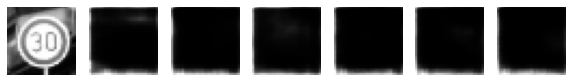

Epoch 331 g_loss= 1.247629 d_loss= 0.8486247 real_acc= 0.92 fake_acc= 1.0
Epoch 332 g_loss= 1.2533716 d_loss= 0.8247572 real_acc= 0.88 fake_acc= 1.0
Epoch 333 g_loss= 1.2652704 d_loss= 0.7993078 real_acc= 0.94 fake_acc= 1.0
Epoch 334 g_loss= 1.27947 d_loss= 0.7577822 real_acc= 0.92 fake_acc= 1.0
Epoch 335 g_loss= 1.2680091 d_loss= 0.79148185 real_acc= 1.0 fake_acc= 1.0
Epoch 336 g_loss= 1.2625225 d_loss= 0.79220927 real_acc= 0.96 fake_acc= 0.98
Epoch 337 g_loss= 1.2583823 d_loss= 0.79433465 real_acc= 0.94 fake_acc= 0.94
Epoch 338 g_loss= 1.245891 d_loss= 0.80190647 real_acc= 0.94 fake_acc= 0.94
Epoch 339 g_loss= 1.2075673 d_loss= 0.82274663 real_acc= 0.9 fake_acc= 0.92
Epoch 340 g_loss= 1.2112541 d_loss= 0.81170285 real_acc= 0.86 fake_acc= 0.96


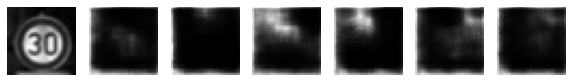

Epoch 341 g_loss= 1.1805171 d_loss= 0.82596594 real_acc= 0.96 fake_acc= 0.82
Epoch 342 g_loss= 1.1642306 d_loss= 0.82112145 real_acc= 0.94 fake_acc= 0.88
Epoch 343 g_loss= 1.2021884 d_loss= 0.820252 real_acc= 0.96 fake_acc= 0.88
Epoch 344 g_loss= 1.182571 d_loss= 0.8806082 real_acc= 0.9 fake_acc= 0.92
Epoch 345 g_loss= 1.1039535 d_loss= 0.919338 real_acc= 0.86 fake_acc= 0.84
Epoch 346 g_loss= 1.0841289 d_loss= 0.8526204 real_acc= 0.96 fake_acc= 0.82
Epoch 347 g_loss= 1.0542779 d_loss= 0.9470296 real_acc= 0.8 fake_acc= 0.76
Epoch 348 g_loss= 1.0396005 d_loss= 0.94259065 real_acc= 0.8 fake_acc= 0.82
Epoch 349 g_loss= 1.0272859 d_loss= 1.0050831 real_acc= 0.78 fake_acc= 0.8
Epoch 350 g_loss= 1.0134668 d_loss= 1.07247 real_acc= 0.72 fake_acc= 0.9


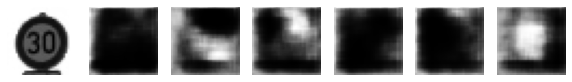

Epoch 351 g_loss= 0.8991749 d_loss= 1.1323302 real_acc= 0.76 fake_acc= 0.86
Epoch 352 g_loss= 0.90607035 d_loss= 1.1107485 real_acc= 0.76 fake_acc= 0.72
Epoch 353 g_loss= 0.8378557 d_loss= 1.2006121 real_acc= 0.64 fake_acc= 0.76
Epoch 354 g_loss= 0.7584209 d_loss= 1.3651817 real_acc= 0.6 fake_acc= 0.52
Epoch 355 g_loss= 0.7375055 d_loss= 1.333451 real_acc= 0.64 fake_acc= 0.54
Epoch 356 g_loss= 0.71869606 d_loss= 1.3974781 real_acc= 0.56 fake_acc= 0.46
Epoch 357 g_loss= 0.6640063 d_loss= 1.3576374 real_acc= 0.68 fake_acc= 0.44
Epoch 358 g_loss= 0.67727053 d_loss= 1.2634785 real_acc= 0.68 fake_acc= 0.4
Epoch 359 g_loss= 0.63097197 d_loss= 1.4891887 real_acc= 0.6 fake_acc= 0.4
Epoch 360 g_loss= 0.6607532 d_loss= 1.4045928 real_acc= 0.56 fake_acc= 0.4


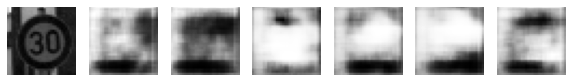

Epoch 361 g_loss= 0.64363307 d_loss= 1.4947393 real_acc= 0.52 fake_acc= 0.4
Epoch 362 g_loss= 0.66014975 d_loss= 1.4652052 real_acc= 0.62 fake_acc= 0.38
Epoch 363 g_loss= 0.7018663 d_loss= 1.4702637 real_acc= 0.58 fake_acc= 0.54
Epoch 364 g_loss= 0.6939701 d_loss= 1.5441413 real_acc= 0.48 fake_acc= 0.52
Epoch 365 g_loss= 0.7084647 d_loss= 1.537355 real_acc= 0.5 fake_acc= 0.5
Epoch 366 g_loss= 0.7228933 d_loss= 1.4083104 real_acc= 0.58 fake_acc= 0.5
Epoch 367 g_loss= 0.71796554 d_loss= 1.4463922 real_acc= 0.52 fake_acc= 0.48
Epoch 368 g_loss= 0.7778151 d_loss= 1.5151775 real_acc= 0.48 fake_acc= 0.68
Epoch 369 g_loss= 0.75599176 d_loss= 1.3570775 real_acc= 0.6 fake_acc= 0.58
Epoch 370 g_loss= 0.7833791 d_loss= 1.3531626 real_acc= 0.56 fake_acc= 0.72


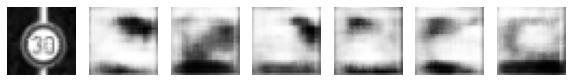

Epoch 371 g_loss= 0.761969 d_loss= 1.4206202 real_acc= 0.58 fake_acc= 0.58
Epoch 372 g_loss= 0.7921002 d_loss= 1.4736202 real_acc= 0.5 fake_acc= 0.7
Epoch 373 g_loss= 0.82748544 d_loss= 1.3354285 real_acc= 0.62 fake_acc= 0.78
Epoch 374 g_loss= 0.78167 d_loss= 1.3868499 real_acc= 0.6 fake_acc= 0.7
Epoch 375 g_loss= 0.79186493 d_loss= 1.4163506 real_acc= 0.5 fake_acc= 0.6
Epoch 376 g_loss= 0.7925584 d_loss= 1.261532 real_acc= 0.74 fake_acc= 0.64
Epoch 377 g_loss= 0.7971919 d_loss= 1.4267004 real_acc= 0.44 fake_acc= 0.68
Epoch 378 g_loss= 0.75834465 d_loss= 1.2910975 real_acc= 0.7 fake_acc= 0.54
Epoch 379 g_loss= 0.7880191 d_loss= 1.3005933 real_acc= 0.68 fake_acc= 0.56
Epoch 380 g_loss= 0.7755568 d_loss= 1.3416705 real_acc= 0.62 fake_acc= 0.62


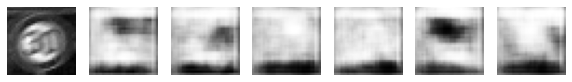

Epoch 381 g_loss= 0.7754285 d_loss= 1.3547995 real_acc= 0.58 fake_acc= 0.62
Epoch 382 g_loss= 0.7777896 d_loss= 1.2814083 real_acc= 0.66 fake_acc= 0.64
Epoch 383 g_loss= 0.7777263 d_loss= 1.2892866 real_acc= 0.62 fake_acc= 0.6
Epoch 384 g_loss= 0.7828803 d_loss= 1.2647922 real_acc= 0.6 fake_acc= 0.56
Epoch 385 g_loss= 0.777178 d_loss= 1.1681209 real_acc= 0.8 fake_acc= 0.64
Epoch 386 g_loss= 0.76613253 d_loss= 1.2672753 real_acc= 0.64 fake_acc= 0.52
Epoch 387 g_loss= 0.78515184 d_loss= 1.2203519 real_acc= 0.68 fake_acc= 0.64
Epoch 388 g_loss= 0.7827639 d_loss= 1.2759306 real_acc= 0.68 fake_acc= 0.64
Epoch 389 g_loss= 0.8033047 d_loss= 1.2067134 real_acc= 0.74 fake_acc= 0.68
Epoch 390 g_loss= 0.79871976 d_loss= 1.3089533 real_acc= 0.62 fake_acc= 0.6


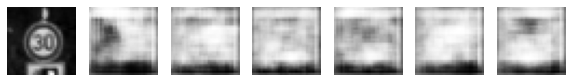

Epoch 391 g_loss= 0.8059286 d_loss= 1.2045724 real_acc= 0.68 fake_acc= 0.64
Epoch 392 g_loss= 0.80580384 d_loss= 1.1445162 real_acc= 0.82 fake_acc= 0.68
Epoch 393 g_loss= 0.8290784 d_loss= 1.1817362 real_acc= 0.78 fake_acc= 0.74
Epoch 394 g_loss= 0.8102623 d_loss= 1.2488302 real_acc= 0.62 fake_acc= 0.64
Epoch 395 g_loss= 0.8170594 d_loss= 1.179576 real_acc= 0.74 fake_acc= 0.72
Epoch 396 g_loss= 0.817486 d_loss= 1.1368966 real_acc= 0.86 fake_acc= 0.66
Epoch 397 g_loss= 0.81475616 d_loss= 1.1743475 real_acc= 0.7 fake_acc= 0.64
Epoch 398 g_loss= 0.8118389 d_loss= 1.1744313 real_acc= 0.76 fake_acc= 0.66
Epoch 399 g_loss= 0.83869463 d_loss= 1.2029507 real_acc= 0.78 fake_acc= 0.74
Epoch 400 g_loss= 0.8132156 d_loss= 1.189383 real_acc= 0.76 fake_acc= 0.7


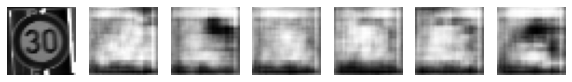

Epoch 401 g_loss= 0.82122475 d_loss= 1.168056 real_acc= 0.72 fake_acc= 0.78
Epoch 402 g_loss= 0.8190877 d_loss= 1.1925855 real_acc= 0.74 fake_acc= 0.72
Epoch 403 g_loss= 0.79733086 d_loss= 1.1299057 real_acc= 0.88 fake_acc= 0.74
Epoch 404 g_loss= 0.7731436 d_loss= 1.2126288 real_acc= 0.8 fake_acc= 0.72
Epoch 405 g_loss= 0.76330304 d_loss= 1.1748395 real_acc= 0.84 fake_acc= 0.66
Epoch 406 g_loss= 0.75459534 d_loss= 1.179422 real_acc= 0.88 fake_acc= 0.62
Epoch 407 g_loss= 0.73854995 d_loss= 1.1930544 real_acc= 0.84 fake_acc= 0.6
Epoch 408 g_loss= 0.73391044 d_loss= 1.1789248 real_acc= 0.84 fake_acc= 0.62
Epoch 409 g_loss= 0.7135341 d_loss= 1.2795541 real_acc= 0.7 fake_acc= 0.54
Epoch 410 g_loss= 0.7061203 d_loss= 1.2514939 real_acc= 0.82 fake_acc= 0.6


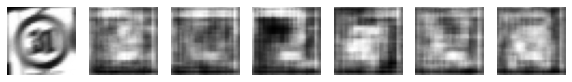

Epoch 411 g_loss= 0.69393 d_loss= 1.1622491 real_acc= 0.9 fake_acc= 0.5
Epoch 412 g_loss= 0.69040793 d_loss= 1.2359681 real_acc= 0.84 fake_acc= 0.54
Epoch 413 g_loss= 0.6547367 d_loss= 1.3282106 real_acc= 0.7 fake_acc= 0.36
Epoch 414 g_loss= 0.6431427 d_loss= 1.3186853 real_acc= 0.84 fake_acc= 0.3
Epoch 415 g_loss= 0.61168545 d_loss= 1.3395884 real_acc= 0.74 fake_acc= 0.14
Epoch 416 g_loss= 0.5869365 d_loss= 1.398379 real_acc= 0.7 fake_acc= 0.04
Epoch 417 g_loss= 0.57757306 d_loss= 1.381655 real_acc= 0.82 fake_acc= 0.02
Epoch 418 g_loss= 0.5559433 d_loss= 1.361674 real_acc= 0.88 fake_acc= 0.02
Epoch 419 g_loss= 0.52544004 d_loss= 1.4734039 real_acc= 0.7 fake_acc= 0.0
Epoch 420 g_loss= 0.5224657 d_loss= 1.4707726 real_acc= 0.8 fake_acc= 0.0


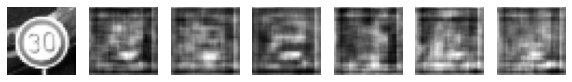

Epoch 421 g_loss= 0.51685864 d_loss= 1.5231369 real_acc= 0.7 fake_acc= 0.0
Epoch 422 g_loss= 0.49817657 d_loss= 1.5297978 real_acc= 0.74 fake_acc= 0.0
Epoch 423 g_loss= 0.5005098 d_loss= 1.5556781 real_acc= 0.7 fake_acc= 0.0
Epoch 424 g_loss= 0.4804281 d_loss= 1.6329441 real_acc= 0.62 fake_acc= 0.0
Epoch 425 g_loss= 0.48058167 d_loss= 1.5778668 real_acc= 0.7 fake_acc= 0.0
Epoch 426 g_loss= 0.46853143 d_loss= 1.635663 real_acc= 0.66 fake_acc= 0.0
Epoch 427 g_loss= 0.4694319 d_loss= 1.5668004 real_acc= 0.68 fake_acc= 0.0
Epoch 428 g_loss= 0.4663337 d_loss= 1.584297 real_acc= 0.76 fake_acc= 0.0
Epoch 429 g_loss= 0.47934437 d_loss= 1.5901233 real_acc= 0.72 fake_acc= 0.0
Epoch 430 g_loss= 0.471962 d_loss= 1.546231 real_acc= 0.76 fake_acc= 0.0


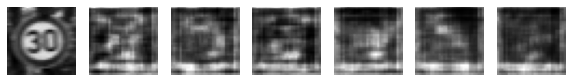

Epoch 431 g_loss= 0.48892036 d_loss= 1.5766823 real_acc= 0.62 fake_acc= 0.0
Epoch 432 g_loss= 0.48974553 d_loss= 1.5397716 real_acc= 0.76 fake_acc= 0.0
Epoch 433 g_loss= 0.503377 d_loss= 1.5533025 real_acc= 0.7 fake_acc= 0.02
Epoch 434 g_loss= 0.51478815 d_loss= 1.5488808 real_acc= 0.64 fake_acc= 0.02
Epoch 435 g_loss= 0.54635763 d_loss= 1.3996754 real_acc= 0.8 fake_acc= 0.0
Epoch 436 g_loss= 0.5676571 d_loss= 1.3732255 real_acc= 0.86 fake_acc= 0.02
Epoch 437 g_loss= 0.58697957 d_loss= 1.4166889 real_acc= 0.68 fake_acc= 0.02
Epoch 438 g_loss= 0.61195153 d_loss= 1.351901 real_acc= 0.72 fake_acc= 0.08
Epoch 439 g_loss= 0.632436 d_loss= 1.359349 real_acc= 0.66 fake_acc= 0.16
Epoch 440 g_loss= 0.6769638 d_loss= 1.3069636 real_acc= 0.68 fake_acc= 0.44


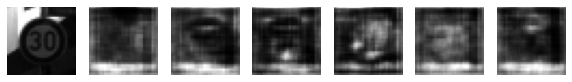

Epoch 441 g_loss= 0.7132266 d_loss= 1.3064415 real_acc= 0.56 fake_acc= 0.58
Epoch 442 g_loss= 0.7184063 d_loss= 1.2508637 real_acc= 0.68 fake_acc= 0.54
Epoch 443 g_loss= 0.76495063 d_loss= 1.2141478 real_acc= 0.66 fake_acc= 0.8
Epoch 444 g_loss= 0.806472 d_loss= 1.2163942 real_acc= 0.68 fake_acc= 0.88
Epoch 445 g_loss= 0.8265221 d_loss= 1.2046386 real_acc= 0.6 fake_acc= 0.9
Epoch 446 g_loss= 0.85052305 d_loss= 1.1309843 real_acc= 0.7 fake_acc= 0.98
Epoch 447 g_loss= 0.86705625 d_loss= 1.1380059 real_acc= 0.7 fake_acc= 1.0
Epoch 448 g_loss= 0.90614164 d_loss= 1.1291847 real_acc= 0.64 fake_acc= 0.94
Epoch 449 g_loss= 0.9338338 d_loss= 1.0914143 real_acc= 0.7 fake_acc= 0.94
Epoch 450 g_loss= 0.9306575 d_loss= 1.1042277 real_acc= 0.6 fake_acc= 0.98


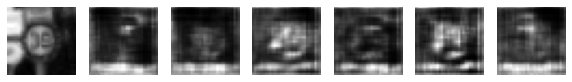

Epoch 451 g_loss= 0.9522967 d_loss= 1.087122 real_acc= 0.64 fake_acc= 1.0
Epoch 452 g_loss= 0.9605704 d_loss= 1.0785849 real_acc= 0.68 fake_acc= 0.96
Epoch 453 g_loss= 0.9789486 d_loss= 1.086941 real_acc= 0.62 fake_acc= 1.0
Epoch 454 g_loss= 0.9651104 d_loss= 1.056577 real_acc= 0.72 fake_acc= 0.98
Epoch 455 g_loss= 0.95963305 d_loss= 1.0601615 real_acc= 0.78 fake_acc= 0.94
Epoch 456 g_loss= 0.95506257 d_loss= 1.0827296 real_acc= 0.64 fake_acc= 0.9
Epoch 457 g_loss= 0.9640091 d_loss= 1.0201211 real_acc= 0.74 fake_acc= 0.9
Epoch 458 g_loss= 0.93455297 d_loss= 1.0485795 real_acc= 0.74 fake_acc= 0.96
Epoch 459 g_loss= 0.92820936 d_loss= 1.0316987 real_acc= 0.8 fake_acc= 0.94
Epoch 460 g_loss= 0.9198388 d_loss= 1.0553268 real_acc= 0.76 fake_acc= 0.86


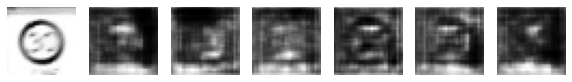

Epoch 461 g_loss= 0.89505625 d_loss= 1.0768183 real_acc= 0.74 fake_acc= 0.84
Epoch 462 g_loss= 0.8864618 d_loss= 1.1000966 real_acc= 0.78 fake_acc= 0.8
Epoch 463 g_loss= 0.8740442 d_loss= 1.1542075 real_acc= 0.56 fake_acc= 0.78
Epoch 464 g_loss= 0.8690983 d_loss= 1.1426852 real_acc= 0.72 fake_acc= 0.76
Epoch 465 g_loss= 0.8558289 d_loss= 1.2451148 real_acc= 0.52 fake_acc= 0.74
Epoch 466 g_loss= 0.83626634 d_loss= 1.2186304 real_acc= 0.56 fake_acc= 0.74
Epoch 467 g_loss= 0.8077136 d_loss= 1.2911241 real_acc= 0.54 fake_acc= 0.66
Epoch 468 g_loss= 0.81109357 d_loss= 1.2273238 real_acc= 0.68 fake_acc= 0.72
Epoch 469 g_loss= 0.8068374 d_loss= 1.2272758 real_acc= 0.58 fake_acc= 0.64
Epoch 470 g_loss= 0.7733223 d_loss= 1.3158809 real_acc= 0.56 fake_acc= 0.62


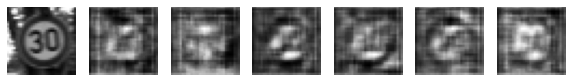

Epoch 471 g_loss= 0.7647245 d_loss= 1.3128729 real_acc= 0.46 fake_acc= 0.64
Epoch 472 g_loss= 0.7850725 d_loss= 1.3130728 real_acc= 0.52 fake_acc= 0.7
Epoch 473 g_loss= 0.7857579 d_loss= 1.3400011 real_acc= 0.46 fake_acc= 0.72
Epoch 474 g_loss= 0.758885 d_loss= 1.4057558 real_acc= 0.4 fake_acc= 0.62
Epoch 475 g_loss= 0.73841906 d_loss= 1.4040647 real_acc= 0.5 fake_acc= 0.58
Epoch 476 g_loss= 0.7488516 d_loss= 1.3418909 real_acc= 0.54 fake_acc= 0.62
Epoch 477 g_loss= 0.7340455 d_loss= 1.4665725 real_acc= 0.46 fake_acc= 0.56
Epoch 478 g_loss= 0.7082696 d_loss= 1.4345 real_acc= 0.46 fake_acc= 0.52
Epoch 479 g_loss= 0.6884021 d_loss= 1.5347435 real_acc= 0.32 fake_acc= 0.5
Epoch 480 g_loss= 0.68529266 d_loss= 1.4488863 real_acc= 0.34 fake_acc= 0.4


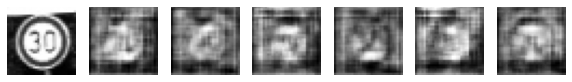

Epoch 481 g_loss= 0.6844423 d_loss= 1.4730825 real_acc= 0.46 fake_acc= 0.48
Epoch 482 g_loss= 0.65498054 d_loss= 1.4884591 real_acc= 0.5 fake_acc= 0.34
Epoch 483 g_loss= 0.66328585 d_loss= 1.5296202 real_acc= 0.34 fake_acc= 0.36
Epoch 484 g_loss= 0.6476917 d_loss= 1.4810567 real_acc= 0.4 fake_acc= 0.34
Epoch 485 g_loss= 0.66716117 d_loss= 1.4811453 real_acc= 0.44 fake_acc= 0.4
Epoch 486 g_loss= 0.65910995 d_loss= 1.4757771 real_acc= 0.54 fake_acc= 0.32
Epoch 487 g_loss= 0.6615435 d_loss= 1.4999895 real_acc= 0.5 fake_acc= 0.28
Epoch 488 g_loss= 0.65673965 d_loss= 1.4915097 real_acc= 0.44 fake_acc= 0.38
Epoch 489 g_loss= 0.6609088 d_loss= 1.5094936 real_acc= 0.44 fake_acc= 0.38
Epoch 490 g_loss= 0.67329055 d_loss= 1.5078497 real_acc= 0.32 fake_acc= 0.46


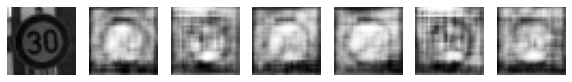

Epoch 491 g_loss= 0.67563194 d_loss= 1.5045911 real_acc= 0.34 fake_acc= 0.42
Epoch 492 g_loss= 0.6899523 d_loss= 1.4580798 real_acc= 0.36 fake_acc= 0.4
Epoch 493 g_loss= 0.6733105 d_loss= 1.5068233 real_acc= 0.46 fake_acc= 0.4
Epoch 494 g_loss= 0.66911477 d_loss= 1.4719613 real_acc= 0.44 fake_acc= 0.4
Epoch 495 g_loss= 0.68468875 d_loss= 1.5111009 real_acc= 0.28 fake_acc= 0.38
Epoch 496 g_loss= 0.68789065 d_loss= 1.4756613 real_acc= 0.36 fake_acc= 0.46
Epoch 497 g_loss= 0.68759745 d_loss= 1.4588665 real_acc= 0.4 fake_acc= 0.52
Epoch 498 g_loss= 0.707659 d_loss= 1.4357814 real_acc= 0.42 fake_acc= 0.6
Epoch 499 g_loss= 0.71680266 d_loss= 1.4639671 real_acc= 0.34 fake_acc= 0.68
Epoch 500 g_loss= 0.71668357 d_loss= 1.5070865 real_acc= 0.18 fake_acc= 0.7


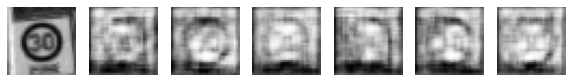

Epoch 501 g_loss= 0.73025733 d_loss= 1.4449613 real_acc= 0.38 fake_acc= 0.62
Epoch 502 g_loss= 0.7218588 d_loss= 1.4463208 real_acc= 0.34 fake_acc= 0.7
Epoch 503 g_loss= 0.74241656 d_loss= 1.4301469 real_acc= 0.28 fake_acc= 0.74
Epoch 504 g_loss= 0.7580157 d_loss= 1.3922873 real_acc= 0.44 fake_acc= 0.72
Epoch 505 g_loss= 0.75300425 d_loss= 1.3783045 real_acc= 0.36 fake_acc= 0.82
Epoch 506 g_loss= 0.7546487 d_loss= 1.4373857 real_acc= 0.24 fake_acc= 0.8
Epoch 507 g_loss= 0.7468882 d_loss= 1.4333091 real_acc= 0.32 fake_acc= 0.8
Epoch 508 g_loss= 0.75306153 d_loss= 1.459295 real_acc= 0.22 fake_acc= 0.82
Epoch 509 g_loss= 0.72846955 d_loss= 1.4161406 real_acc= 0.36 fake_acc= 0.68
Epoch 510 g_loss= 0.74556977 d_loss= 1.4155269 real_acc= 0.32 fake_acc= 0.76


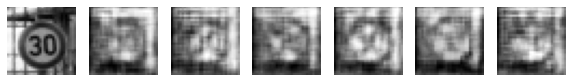

Epoch 511 g_loss= 0.7508025 d_loss= 1.3943734 real_acc= 0.28 fake_acc= 0.8
Epoch 512 g_loss= 0.733408 d_loss= 1.4337926 real_acc= 0.34 fake_acc= 0.74
Epoch 513 g_loss= 0.74747306 d_loss= 1.4001709 real_acc= 0.32 fake_acc= 0.76
Epoch 514 g_loss= 0.7502269 d_loss= 1.3892856 real_acc= 0.36 fake_acc= 0.84
Epoch 515 g_loss= 0.7496902 d_loss= 1.3811333 real_acc= 0.36 fake_acc= 0.8
Epoch 516 g_loss= 0.755486 d_loss= 1.3730769 real_acc= 0.3 fake_acc= 0.82
Epoch 517 g_loss= 0.7746708 d_loss= 1.4376409 real_acc= 0.22 fake_acc= 0.9
Epoch 518 g_loss= 0.7647226 d_loss= 1.4094956 real_acc= 0.32 fake_acc= 0.92
Epoch 519 g_loss= 0.761256 d_loss= 1.4326398 real_acc= 0.2 fake_acc= 0.86
Epoch 520 g_loss= 0.76810694 d_loss= 1.3939245 real_acc= 0.28 fake_acc= 0.92


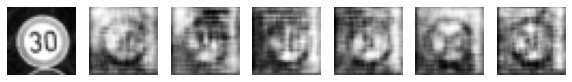

Epoch 521 g_loss= 0.7517907 d_loss= 1.4173074 real_acc= 0.28 fake_acc= 0.88
Epoch 522 g_loss= 0.7617379 d_loss= 1.405816 real_acc= 0.26 fake_acc= 0.88
Epoch 523 g_loss= 0.75645465 d_loss= 1.4431252 real_acc= 0.24 fake_acc= 0.92
Epoch 524 g_loss= 0.7412002 d_loss= 1.4454176 real_acc= 0.18 fake_acc= 0.82
Epoch 525 g_loss= 0.7501115 d_loss= 1.3899052 real_acc= 0.4 fake_acc= 0.84
Epoch 526 g_loss= 0.7428599 d_loss= 1.4324746 real_acc= 0.28 fake_acc= 0.76
Epoch 527 g_loss= 0.75075185 d_loss= 1.4893949 real_acc= 0.16 fake_acc= 0.82
Epoch 528 g_loss= 0.7585397 d_loss= 1.4241519 real_acc= 0.24 fake_acc= 0.8
Epoch 529 g_loss= 0.7428091 d_loss= 1.4184666 real_acc= 0.32 fake_acc= 0.82
Epoch 530 g_loss= 0.7585921 d_loss= 1.5025424 real_acc= 0.16 fake_acc= 0.84


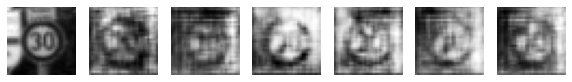

Epoch 531 g_loss= 0.7448061 d_loss= 1.4290578 real_acc= 0.28 fake_acc= 0.78
Epoch 532 g_loss= 0.7509397 d_loss= 1.4329965 real_acc= 0.3 fake_acc= 0.88
Epoch 533 g_loss= 0.74527746 d_loss= 1.4572434 real_acc= 0.32 fake_acc= 0.82
Epoch 534 g_loss= 0.7401393 d_loss= 1.4560502 real_acc= 0.22 fake_acc= 0.7
Epoch 535 g_loss= 0.7372251 d_loss= 1.4633176 real_acc= 0.28 fake_acc= 0.68
Epoch 536 g_loss= 0.7319559 d_loss= 1.433564 real_acc= 0.38 fake_acc= 0.62
Epoch 537 g_loss= 0.72434396 d_loss= 1.4800017 real_acc= 0.38 fake_acc= 0.68
Epoch 538 g_loss= 0.71142495 d_loss= 1.4600217 real_acc= 0.42 fake_acc= 0.56
Epoch 539 g_loss= 0.72149324 d_loss= 1.5008981 real_acc= 0.26 fake_acc= 0.68
Epoch 540 g_loss= 0.7214323 d_loss= 1.4500209 real_acc= 0.36 fake_acc= 0.52


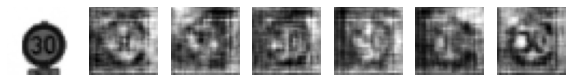

Epoch 541 g_loss= 0.7106087 d_loss= 1.4330913 real_acc= 0.4 fake_acc= 0.54
Epoch 542 g_loss= 0.7199578 d_loss= 1.5220101 real_acc= 0.3 fake_acc= 0.62
Epoch 543 g_loss= 0.722314 d_loss= 1.4954312 real_acc= 0.34 fake_acc= 0.56
Epoch 544 g_loss= 0.7130876 d_loss= 1.5018811 real_acc= 0.42 fake_acc= 0.58
Epoch 545 g_loss= 0.69616884 d_loss= 1.4507968 real_acc= 0.56 fake_acc= 0.46
Epoch 546 g_loss= 0.697834 d_loss= 1.485132 real_acc= 0.38 fake_acc= 0.56
Epoch 547 g_loss= 0.69652647 d_loss= 1.4564977 real_acc= 0.48 fake_acc= 0.46
Epoch 548 g_loss= 0.69557184 d_loss= 1.45682 real_acc= 0.44 fake_acc= 0.54
Epoch 549 g_loss= 0.6928742 d_loss= 1.4797771 real_acc= 0.44 fake_acc= 0.54
Epoch 550 g_loss= 0.69808686 d_loss= 1.4701037 real_acc= 0.42 fake_acc= 0.4


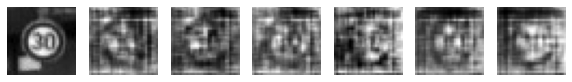

Epoch 551 g_loss= 0.6980463 d_loss= 1.4603937 real_acc= 0.42 fake_acc= 0.54
Epoch 552 g_loss= 0.6922571 d_loss= 1.4601243 real_acc= 0.36 fake_acc= 0.48
Epoch 553 g_loss= 0.7020116 d_loss= 1.4525106 real_acc= 0.5 fake_acc= 0.6
Epoch 554 g_loss= 0.6922701 d_loss= 1.4696169 real_acc= 0.46 fake_acc= 0.46
Epoch 555 g_loss= 0.68893796 d_loss= 1.5387685 real_acc= 0.26 fake_acc= 0.38
Epoch 556 g_loss= 0.70005697 d_loss= 1.4529626 real_acc= 0.48 fake_acc= 0.56
Epoch 557 g_loss= 0.6800513 d_loss= 1.4801236 real_acc= 0.5 fake_acc= 0.38
Epoch 558 g_loss= 0.67037576 d_loss= 1.4287524 real_acc= 0.64 fake_acc= 0.3
Epoch 559 g_loss= 0.67147654 d_loss= 1.4482481 real_acc= 0.5 fake_acc= 0.28
Epoch 560 g_loss= 0.67040503 d_loss= 1.4518708 real_acc= 0.58 fake_acc= 0.28


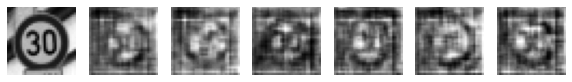

Epoch 561 g_loss= 0.668699 d_loss= 1.424328 real_acc= 0.58 fake_acc= 0.22
Epoch 562 g_loss= 0.6641342 d_loss= 1.4309738 real_acc= 0.58 fake_acc= 0.24
Epoch 563 g_loss= 0.6615622 d_loss= 1.447119 real_acc= 0.56 fake_acc= 0.2
Epoch 564 g_loss= 0.6563868 d_loss= 1.4440563 real_acc= 0.54 fake_acc= 0.12
Epoch 565 g_loss= 0.6486103 d_loss= 1.4506708 real_acc= 0.6 fake_acc= 0.16
Epoch 566 g_loss= 0.65114105 d_loss= 1.4726863 real_acc= 0.5 fake_acc= 0.1
Epoch 567 g_loss= 0.65251166 d_loss= 1.4383096 real_acc= 0.6 fake_acc= 0.16
Epoch 568 g_loss= 0.64246583 d_loss= 1.4478927 real_acc= 0.6 fake_acc= 0.1
Epoch 569 g_loss= 0.6439678 d_loss= 1.4197328 real_acc= 0.6 fake_acc= 0.1
Epoch 570 g_loss= 0.6491909 d_loss= 1.4448938 real_acc= 0.6 fake_acc= 0.06


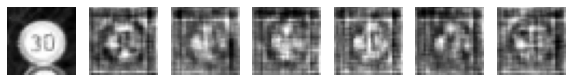

Epoch 571 g_loss= 0.64789444 d_loss= 1.4084398 real_acc= 0.66 fake_acc= 0.06
Epoch 572 g_loss= 0.6437102 d_loss= 1.4038371 real_acc= 0.66 fake_acc= 0.08
Epoch 573 g_loss= 0.6471078 d_loss= 1.415648 real_acc= 0.6 fake_acc= 0.1
Epoch 574 g_loss= 0.63709515 d_loss= 1.4229679 real_acc= 0.66 fake_acc= 0.1
Epoch 575 g_loss= 0.6431705 d_loss= 1.3791945 real_acc= 0.78 fake_acc= 0.04
Epoch 576 g_loss= 0.64221686 d_loss= 1.4108515 real_acc= 0.7 fake_acc= 0.06
Epoch 577 g_loss= 0.64041436 d_loss= 1.3948795 real_acc= 0.64 fake_acc= 0.08
Epoch 578 g_loss= 0.64597136 d_loss= 1.3868046 real_acc= 0.74 fake_acc= 0.02
Epoch 579 g_loss= 0.64291596 d_loss= 1.3696036 real_acc= 0.8 fake_acc= 0.02
Epoch 580 g_loss= 0.64274144 d_loss= 1.4176214 real_acc= 0.58 fake_acc= 0.06


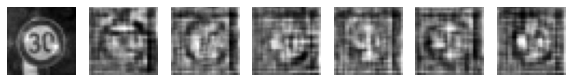

Epoch 581 g_loss= 0.6397942 d_loss= 1.3921177 real_acc= 0.76 fake_acc= 0.0
Epoch 582 g_loss= 0.64156723 d_loss= 1.3985868 real_acc= 0.7 fake_acc= 0.06
Epoch 583 g_loss= 0.6420609 d_loss= 1.4182887 real_acc= 0.6 fake_acc= 0.02
Epoch 584 g_loss= 0.6488159 d_loss= 1.3727443 real_acc= 0.78 fake_acc= 0.1
Epoch 585 g_loss= 0.6520511 d_loss= 1.3973868 real_acc= 0.66 fake_acc= 0.1
Epoch 586 g_loss= 0.6580352 d_loss= 1.3838296 real_acc= 0.68 fake_acc= 0.12
Epoch 587 g_loss= 0.6516172 d_loss= 1.4026278 real_acc= 0.7 fake_acc= 0.12
Epoch 588 g_loss= 0.65702987 d_loss= 1.4038378 real_acc= 0.6 fake_acc= 0.16
Epoch 589 g_loss= 0.6539267 d_loss= 1.4161735 real_acc= 0.66 fake_acc= 0.06
Epoch 590 g_loss= 0.65612596 d_loss= 1.4004816 real_acc= 0.56 fake_acc= 0.16


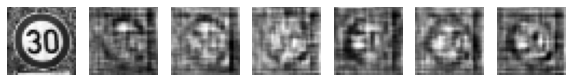

Epoch 591 g_loss= 0.6590312 d_loss= 1.4095788 real_acc= 0.58 fake_acc= 0.26
Epoch 592 g_loss= 0.65302366 d_loss= 1.414701 real_acc= 0.72 fake_acc= 0.08
Epoch 593 g_loss= 0.6477215 d_loss= 1.3806431 real_acc= 0.82 fake_acc= 0.1
Epoch 594 g_loss= 0.6514718 d_loss= 1.4189063 real_acc= 0.62 fake_acc= 0.18
Epoch 595 g_loss= 0.6395121 d_loss= 1.3894849 real_acc= 0.76 fake_acc= 0.02
Epoch 596 g_loss= 0.63453776 d_loss= 1.4165697 real_acc= 0.72 fake_acc= 0.06
Epoch 597 g_loss= 0.63413405 d_loss= 1.3856187 real_acc= 0.8 fake_acc= 0.06
Epoch 598 g_loss= 0.63195056 d_loss= 1.3791409 real_acc= 0.72 fake_acc= 0.06
Epoch 599 g_loss= 0.63043654 d_loss= 1.4350132 real_acc= 0.6 fake_acc= 0.02
Epoch 600 g_loss= 0.6258744 d_loss= 1.4384878 real_acc= 0.64 fake_acc= 0.0


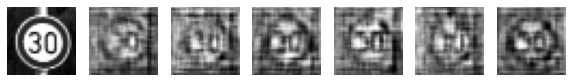

Epoch 601 g_loss= 0.62987053 d_loss= 1.4527284 real_acc= 0.54 fake_acc= 0.02
Epoch 602 g_loss= 0.61657816 d_loss= 1.4526229 real_acc= 0.6 fake_acc= 0.0
Epoch 603 g_loss= 0.6169998 d_loss= 1.415814 real_acc= 0.68 fake_acc= 0.0
Epoch 604 g_loss= 0.61216855 d_loss= 1.4444864 real_acc= 0.64 fake_acc= 0.0
Epoch 605 g_loss= 0.60638803 d_loss= 1.440186 real_acc= 0.68 fake_acc= 0.0
Epoch 606 g_loss= 0.60011554 d_loss= 1.4256575 real_acc= 0.82 fake_acc= 0.0
Epoch 607 g_loss= 0.59934205 d_loss= 1.4240801 real_acc= 0.76 fake_acc= 0.0
Epoch 608 g_loss= 0.5958722 d_loss= 1.4299729 real_acc= 0.84 fake_acc= 0.0
Epoch 609 g_loss= 0.59667087 d_loss= 1.4557563 real_acc= 0.7 fake_acc= 0.0
Epoch 610 g_loss= 0.60146064 d_loss= 1.4377644 real_acc= 0.7 fake_acc= 0.02


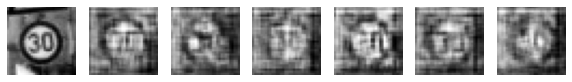

Epoch 611 g_loss= 0.59562 d_loss= 1.4440634 real_acc= 0.8 fake_acc= 0.0
Epoch 612 g_loss= 0.5902558 d_loss= 1.4266644 real_acc= 0.78 fake_acc= 0.0
Epoch 613 g_loss= 0.58970785 d_loss= 1.4394263 real_acc= 0.8 fake_acc= 0.0
Epoch 614 g_loss= 0.5940129 d_loss= 1.4304748 real_acc= 0.78 fake_acc= 0.0
Epoch 615 g_loss= 0.5917969 d_loss= 1.4289505 real_acc= 0.76 fake_acc= 0.0
Epoch 616 g_loss= 0.5915833 d_loss= 1.4433777 real_acc= 0.84 fake_acc= 0.0
Epoch 617 g_loss= 0.59550273 d_loss= 1.4193072 real_acc= 0.88 fake_acc= 0.0
Epoch 618 g_loss= 0.59762174 d_loss= 1.4275254 real_acc= 0.76 fake_acc= 0.0
Epoch 619 g_loss= 0.60112214 d_loss= 1.4185783 real_acc= 0.86 fake_acc= 0.0
Epoch 620 g_loss= 0.5978234 d_loss= 1.3976607 real_acc= 0.88 fake_acc= 0.0


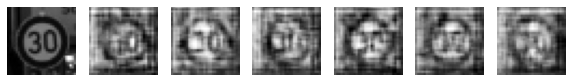

Epoch 621 g_loss= 0.6015951 d_loss= 1.4196165 real_acc= 0.82 fake_acc= 0.0
Epoch 622 g_loss= 0.60452825 d_loss= 1.4168773 real_acc= 0.86 fake_acc= 0.0
Epoch 623 g_loss= 0.6015144 d_loss= 1.4159019 real_acc= 0.8 fake_acc= 0.0
Epoch 624 g_loss= 0.60536647 d_loss= 1.4276837 real_acc= 0.8 fake_acc= 0.0
Epoch 625 g_loss= 0.6132884 d_loss= 1.3976681 real_acc= 0.84 fake_acc= 0.0
Epoch 626 g_loss= 0.6137078 d_loss= 1.4137177 real_acc= 0.82 fake_acc= 0.0
Epoch 627 g_loss= 0.6164274 d_loss= 1.3967543 real_acc= 0.88 fake_acc= 0.0
Epoch 628 g_loss= 0.6214044 d_loss= 1.3915901 real_acc= 0.9 fake_acc= 0.0
Epoch 629 g_loss= 0.62910104 d_loss= 1.4103624 real_acc= 0.82 fake_acc= 0.0
Epoch 630 g_loss= 0.6357602 d_loss= 1.3851993 real_acc= 0.82 fake_acc= 0.02


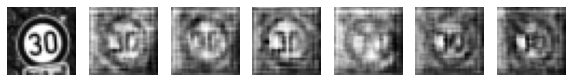

Epoch 631 g_loss= 0.63670594 d_loss= 1.4075785 real_acc= 0.72 fake_acc= 0.04
Epoch 632 g_loss= 0.63738406 d_loss= 1.395304 real_acc= 0.84 fake_acc= 0.0
Epoch 633 g_loss= 0.63986164 d_loss= 1.400744 real_acc= 0.76 fake_acc= 0.0
Epoch 634 g_loss= 0.644314 d_loss= 1.3977711 real_acc= 0.78 fake_acc= 0.06
Epoch 635 g_loss= 0.6456771 d_loss= 1.4091775 real_acc= 0.64 fake_acc= 0.02
Epoch 636 g_loss= 0.64706004 d_loss= 1.4019189 real_acc= 0.7 fake_acc= 0.08
Epoch 637 g_loss= 0.65523833 d_loss= 1.3874938 real_acc= 0.76 fake_acc= 0.12
Epoch 638 g_loss= 0.65263903 d_loss= 1.372211 real_acc= 0.76 fake_acc= 0.06
Epoch 639 g_loss= 0.6555195 d_loss= 1.4186141 real_acc= 0.64 fake_acc= 0.08
Epoch 640 g_loss= 0.65740097 d_loss= 1.3988515 real_acc= 0.66 fake_acc= 0.16


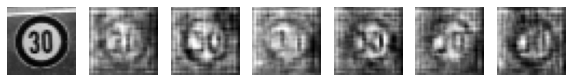

Epoch 641 g_loss= 0.6654541 d_loss= 1.401535 real_acc= 0.54 fake_acc= 0.18
Epoch 642 g_loss= 0.65512586 d_loss= 1.4004904 real_acc= 0.72 fake_acc= 0.12
Epoch 643 g_loss= 0.6578794 d_loss= 1.3889686 real_acc= 0.62 fake_acc= 0.24
Epoch 644 g_loss= 0.6544873 d_loss= 1.3828673 real_acc= 0.8 fake_acc= 0.12
Epoch 645 g_loss= 0.65785444 d_loss= 1.4115356 real_acc= 0.62 fake_acc= 0.14
Epoch 646 g_loss= 0.6591369 d_loss= 1.3965669 real_acc= 0.7 fake_acc= 0.18
Epoch 647 g_loss= 0.65796244 d_loss= 1.4168408 real_acc= 0.62 fake_acc= 0.12
Epoch 648 g_loss= 0.660023 d_loss= 1.3982975 real_acc= 0.68 fake_acc= 0.08
Epoch 649 g_loss= 0.6687343 d_loss= 1.3808689 real_acc= 0.6 fake_acc= 0.16
Epoch 650 g_loss= 0.66277725 d_loss= 1.3907726 real_acc= 0.64 fake_acc= 0.16


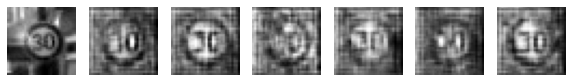

Epoch 651 g_loss= 0.6585186 d_loss= 1.3881297 real_acc= 0.8 fake_acc= 0.16
Epoch 652 g_loss= 0.6578475 d_loss= 1.3950337 real_acc= 0.66 fake_acc= 0.1
Epoch 653 g_loss= 0.6607241 d_loss= 1.3992665 real_acc= 0.66 fake_acc= 0.14
Epoch 654 g_loss= 0.66285396 d_loss= 1.3996881 real_acc= 0.56 fake_acc= 0.16
Epoch 655 g_loss= 0.6512442 d_loss= 1.386188 real_acc= 0.74 fake_acc= 0.06
Epoch 656 g_loss= 0.653699 d_loss= 1.415556 real_acc= 0.52 fake_acc= 0.08
Epoch 657 g_loss= 0.65638244 d_loss= 1.3843067 real_acc= 0.72 fake_acc= 0.1
Epoch 658 g_loss= 0.65053695 d_loss= 1.4112821 real_acc= 0.66 fake_acc= 0.04
Epoch 659 g_loss= 0.64930815 d_loss= 1.388401 real_acc= 0.66 fake_acc= 0.02
Epoch 660 g_loss= 0.64394766 d_loss= 1.4291022 real_acc= 0.58 fake_acc= 0.04


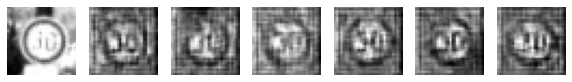

Epoch 661 g_loss= 0.64298135 d_loss= 1.406569 real_acc= 0.7 fake_acc= 0.0
Epoch 662 g_loss= 0.644011 d_loss= 1.3912791 real_acc= 0.76 fake_acc= 0.06
Epoch 663 g_loss= 0.64339536 d_loss= 1.4079919 real_acc= 0.66 fake_acc= 0.02
Epoch 664 g_loss= 0.64463365 d_loss= 1.3948008 real_acc= 0.68 fake_acc= 0.1
Epoch 665 g_loss= 0.64390516 d_loss= 1.3976756 real_acc= 0.7 fake_acc= 0.06
Epoch 666 g_loss= 0.64603937 d_loss= 1.3999163 real_acc= 0.76 fake_acc= 0.06
Epoch 667 g_loss= 0.65002596 d_loss= 1.4002862 real_acc= 0.66 fake_acc= 0.1
Epoch 668 g_loss= 0.64812744 d_loss= 1.4006629 real_acc= 0.68 fake_acc= 0.0
Epoch 669 g_loss= 0.64906657 d_loss= 1.411431 real_acc= 0.52 fake_acc= 0.1
Epoch 670 g_loss= 0.6544334 d_loss= 1.4119034 real_acc= 0.54 fake_acc= 0.12


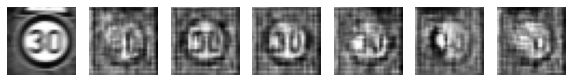

Epoch 671 g_loss= 0.6542212 d_loss= 1.3951724 real_acc= 0.72 fake_acc= 0.06
Epoch 672 g_loss= 0.6562599 d_loss= 1.3979101 real_acc= 0.64 fake_acc= 0.1
Epoch 673 g_loss= 0.65836316 d_loss= 1.4124289 real_acc= 0.5 fake_acc= 0.1
Epoch 674 g_loss= 0.6608159 d_loss= 1.400918 real_acc= 0.64 fake_acc= 0.1
Epoch 675 g_loss= 0.6609738 d_loss= 1.4063903 real_acc= 0.56 fake_acc= 0.16
Epoch 676 g_loss= 0.6672649 d_loss= 1.3911574 real_acc= 0.58 fake_acc= 0.18
Epoch 677 g_loss= 0.6665875 d_loss= 1.4004267 real_acc= 0.46 fake_acc= 0.24
Epoch 678 g_loss= 0.6668311 d_loss= 1.4067678 real_acc= 0.56 fake_acc= 0.2
Epoch 679 g_loss= 0.66676366 d_loss= 1.3995607 real_acc= 0.56 fake_acc= 0.22
Epoch 680 g_loss= 0.6673319 d_loss= 1.4082901 real_acc= 0.48 fake_acc= 0.2


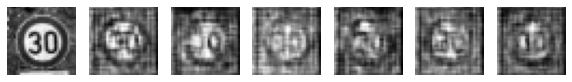

Epoch 681 g_loss= 0.6696867 d_loss= 1.3864841 real_acc= 0.62 fake_acc= 0.18
Epoch 682 g_loss= 0.682975 d_loss= 1.3855237 real_acc= 0.6 fake_acc= 0.38
Epoch 683 g_loss= 0.686228 d_loss= 1.3937112 real_acc= 0.5 fake_acc= 0.48
Epoch 684 g_loss= 0.6769725 d_loss= 1.4136038 real_acc= 0.36 fake_acc= 0.22
Epoch 685 g_loss= 0.68343616 d_loss= 1.403115 real_acc= 0.36 fake_acc= 0.3
Epoch 686 g_loss= 0.6864755 d_loss= 1.411197 real_acc= 0.36 fake_acc= 0.42
Epoch 687 g_loss= 0.68720216 d_loss= 1.4118886 real_acc= 0.28 fake_acc= 0.38
Epoch 688 g_loss= 0.6994089 d_loss= 1.3982903 real_acc= 0.32 fake_acc= 0.64
Epoch 689 g_loss= 0.6940004 d_loss= 1.3902526 real_acc= 0.44 fake_acc= 0.54
Epoch 690 g_loss= 0.6922027 d_loss= 1.3949203 real_acc= 0.44 fake_acc= 0.52


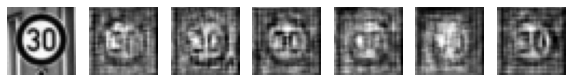

Epoch 691 g_loss= 0.69817615 d_loss= 1.3820112 real_acc= 0.44 fake_acc= 0.62
Epoch 692 g_loss= 0.6879152 d_loss= 1.4106712 real_acc= 0.34 fake_acc= 0.46
Epoch 693 g_loss= 0.6944161 d_loss= 1.3959632 real_acc= 0.38 fake_acc= 0.5
Epoch 694 g_loss= 0.69571066 d_loss= 1.39727 real_acc= 0.34 fake_acc= 0.54
Epoch 695 g_loss= 0.6945589 d_loss= 1.4036229 real_acc= 0.36 fake_acc= 0.46
Epoch 696 g_loss= 0.69700044 d_loss= 1.3752084 real_acc= 0.56 fake_acc= 0.52
Epoch 697 g_loss= 0.6957814 d_loss= 1.398384 real_acc= 0.36 fake_acc= 0.5
Epoch 698 g_loss= 0.6901336 d_loss= 1.3938444 real_acc= 0.42 fake_acc= 0.44
Epoch 699 g_loss= 0.694562 d_loss= 1.3932984 real_acc= 0.34 fake_acc= 0.46
Epoch 700 g_loss= 0.69057566 d_loss= 1.4051495 real_acc= 0.4 fake_acc= 0.44


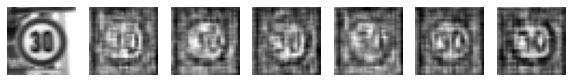

Epoch 701 g_loss= 0.69352007 d_loss= 1.4003189 real_acc= 0.36 fake_acc= 0.54
Epoch 702 g_loss= 0.69394547 d_loss= 1.3854134 real_acc= 0.52 fake_acc= 0.56
Epoch 703 g_loss= 0.6909485 d_loss= 1.4056705 real_acc= 0.36 fake_acc= 0.48
Epoch 704 g_loss= 0.6995868 d_loss= 1.401499 real_acc= 0.28 fake_acc= 0.64
Epoch 705 g_loss= 0.7014212 d_loss= 1.3840218 real_acc= 0.5 fake_acc= 0.64
Epoch 706 g_loss= 0.6968517 d_loss= 1.4096532 real_acc= 0.28 fake_acc= 0.54
Epoch 707 g_loss= 0.6919814 d_loss= 1.3930078 real_acc= 0.48 fake_acc= 0.5
Epoch 708 g_loss= 0.69661355 d_loss= 1.4006735 real_acc= 0.44 fake_acc= 0.6
Epoch 709 g_loss= 0.7016985 d_loss= 1.3978798 real_acc= 0.38 fake_acc= 0.64
Epoch 710 g_loss= 0.69955605 d_loss= 1.3848722 real_acc= 0.42 fake_acc= 0.58


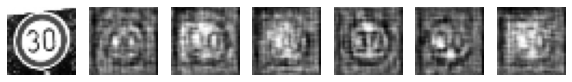

Epoch 711 g_loss= 0.69387984 d_loss= 1.3967028 real_acc= 0.44 fake_acc= 0.42
Epoch 712 g_loss= 0.69458026 d_loss= 1.3953552 real_acc= 0.38 fake_acc= 0.48
Epoch 713 g_loss= 0.694263 d_loss= 1.4091792 real_acc= 0.3 fake_acc= 0.46
Epoch 714 g_loss= 0.68956095 d_loss= 1.3865451 real_acc= 0.58 fake_acc= 0.54
Epoch 715 g_loss= 0.6915591 d_loss= 1.3813903 real_acc= 0.52 fake_acc= 0.54
Epoch 716 g_loss= 0.69253546 d_loss= 1.402132 real_acc= 0.46 fake_acc= 0.5
Epoch 717 g_loss= 0.6939055 d_loss= 1.3924187 real_acc= 0.48 fake_acc= 0.56
Epoch 718 g_loss= 0.69011533 d_loss= 1.3927519 real_acc= 0.38 fake_acc= 0.44
Epoch 719 g_loss= 0.69397134 d_loss= 1.393801 real_acc= 0.54 fake_acc= 0.52
Epoch 720 g_loss= 0.69192433 d_loss= 1.397843 real_acc= 0.42 fake_acc= 0.54


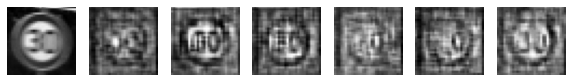

Epoch 721 g_loss= 0.6893975 d_loss= 1.3848988 real_acc= 0.5 fake_acc= 0.4
Epoch 722 g_loss= 0.69421 d_loss= 1.4031856 real_acc= 0.36 fake_acc= 0.56
Epoch 723 g_loss= 0.683545 d_loss= 1.4232299 real_acc= 0.4 fake_acc= 0.4
Epoch 724 g_loss= 0.6840823 d_loss= 1.4111295 real_acc= 0.44 fake_acc= 0.42
Epoch 725 g_loss= 0.6889582 d_loss= 1.4005438 real_acc= 0.5 fake_acc= 0.52
Epoch 726 g_loss= 0.68410593 d_loss= 1.422643 real_acc= 0.38 fake_acc= 0.38
Epoch 727 g_loss= 0.6812658 d_loss= 1.4087696 real_acc= 0.48 fake_acc= 0.36
Epoch 728 g_loss= 0.69858825 d_loss= 1.392327 real_acc= 0.36 fake_acc= 0.68
Epoch 729 g_loss= 0.68683314 d_loss= 1.4114923 real_acc= 0.4 fake_acc= 0.42
Epoch 730 g_loss= 0.6887543 d_loss= 1.4078263 real_acc= 0.4 fake_acc= 0.48


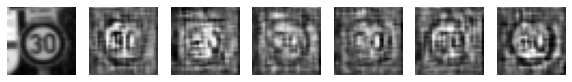

Epoch 731 g_loss= 0.6922524 d_loss= 1.396401 real_acc= 0.42 fake_acc= 0.48
Epoch 732 g_loss= 0.6974771 d_loss= 1.4156282 real_acc= 0.32 fake_acc= 0.56
Epoch 733 g_loss= 0.68486786 d_loss= 1.4031305 real_acc= 0.48 fake_acc= 0.42
Epoch 734 g_loss= 0.687126 d_loss= 1.4078118 real_acc= 0.52 fake_acc= 0.38
Epoch 735 g_loss= 0.69477105 d_loss= 1.4045022 real_acc= 0.38 fake_acc= 0.52
Epoch 736 g_loss= 0.69257104 d_loss= 1.4051969 real_acc= 0.42 fake_acc= 0.46
Epoch 737 g_loss= 0.6845716 d_loss= 1.4023612 real_acc= 0.56 fake_acc= 0.46
Epoch 738 g_loss= 0.68025804 d_loss= 1.4076623 real_acc= 0.44 fake_acc= 0.32
Epoch 739 g_loss= 0.67263794 d_loss= 1.4245191 real_acc= 0.38 fake_acc= 0.24
Epoch 740 g_loss= 0.67273664 d_loss= 1.4053767 real_acc= 0.48 fake_acc= 0.16


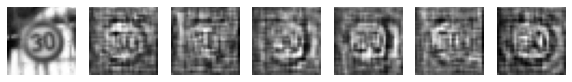

Epoch 741 g_loss= 0.67046547 d_loss= 1.4072157 real_acc= 0.48 fake_acc= 0.18
Epoch 742 g_loss= 0.668651 d_loss= 1.4141743 real_acc= 0.5 fake_acc= 0.18
Epoch 743 g_loss= 0.66166854 d_loss= 1.4230356 real_acc= 0.54 fake_acc= 0.16
Epoch 744 g_loss= 0.66172945 d_loss= 1.4165957 real_acc= 0.56 fake_acc= 0.16
Epoch 745 g_loss= 0.6541582 d_loss= 1.4341804 real_acc= 0.4 fake_acc= 0.08
Epoch 746 g_loss= 0.6537413 d_loss= 1.4227716 real_acc= 0.52 fake_acc= 0.06
Epoch 747 g_loss= 0.6574326 d_loss= 1.4225888 real_acc= 0.56 fake_acc= 0.06
Epoch 748 g_loss= 0.65742004 d_loss= 1.4308732 real_acc= 0.5 fake_acc= 0.06
Epoch 749 g_loss= 0.6524098 d_loss= 1.4188625 real_acc= 0.54 fake_acc= 0.04
Epoch 750 g_loss= 0.65142334 d_loss= 1.4326036 real_acc= 0.56 fake_acc= 0.08


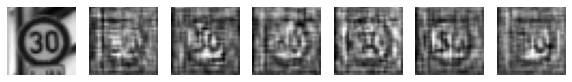

Epoch 751 g_loss= 0.65431166 d_loss= 1.4112821 real_acc= 0.66 fake_acc= 0.08
Epoch 752 g_loss= 0.654519 d_loss= 1.4201548 real_acc= 0.56 fake_acc= 0.04
Epoch 753 g_loss= 0.6449685 d_loss= 1.4302444 real_acc= 0.58 fake_acc= 0.06
Epoch 754 g_loss= 0.6474116 d_loss= 1.4218566 real_acc= 0.6 fake_acc= 0.02
Epoch 755 g_loss= 0.64159757 d_loss= 1.4196514 real_acc= 0.56 fake_acc= 0.0
Epoch 756 g_loss= 0.6352007 d_loss= 1.440999 real_acc= 0.62 fake_acc= 0.0
Epoch 757 g_loss= 0.63505006 d_loss= 1.4231647 real_acc= 0.7 fake_acc= 0.0
Epoch 758 g_loss= 0.6344255 d_loss= 1.4253421 real_acc= 0.74 fake_acc= 0.0
Epoch 759 g_loss= 0.6295337 d_loss= 1.4348102 real_acc= 0.7 fake_acc= 0.0
Epoch 760 g_loss= 0.6325472 d_loss= 1.412429 real_acc= 0.78 fake_acc= 0.0


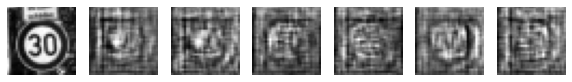

Epoch 761 g_loss= 0.627581 d_loss= 1.4362882 real_acc= 0.76 fake_acc= 0.0
Epoch 762 g_loss= 0.6292528 d_loss= 1.4336228 real_acc= 0.76 fake_acc= 0.0
Epoch 763 g_loss= 0.63239515 d_loss= 1.4259686 real_acc= 0.74 fake_acc= 0.0
Epoch 764 g_loss= 0.6350797 d_loss= 1.4371554 real_acc= 0.66 fake_acc= 0.0
Epoch 765 g_loss= 0.64142394 d_loss= 1.4200876 real_acc= 0.68 fake_acc= 0.0
Epoch 766 g_loss= 0.63853663 d_loss= 1.4241242 real_acc= 0.64 fake_acc= 0.02
Epoch 767 g_loss= 0.6467531 d_loss= 1.4287546 real_acc= 0.5 fake_acc= 0.02
Epoch 768 g_loss= 0.64657736 d_loss= 1.4382457 real_acc= 0.5 fake_acc= 0.06
Epoch 769 g_loss= 0.65765816 d_loss= 1.4234087 real_acc= 0.54 fake_acc= 0.06
Epoch 770 g_loss= 0.65449494 d_loss= 1.4232473 real_acc= 0.46 fake_acc= 0.06


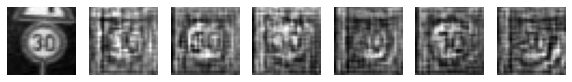

Epoch 771 g_loss= 0.66640085 d_loss= 1.4182814 real_acc= 0.5 fake_acc= 0.24
Epoch 772 g_loss= 0.66511506 d_loss= 1.4196483 real_acc= 0.48 fake_acc= 0.12
Epoch 773 g_loss= 0.6665009 d_loss= 1.4291604 real_acc= 0.36 fake_acc= 0.08
Epoch 774 g_loss= 0.67044455 d_loss= 1.4227071 real_acc= 0.3 fake_acc= 0.22
Epoch 775 g_loss= 0.67902136 d_loss= 1.4097252 real_acc= 0.34 fake_acc= 0.2
Epoch 776 g_loss= 0.67863446 d_loss= 1.4192638 real_acc= 0.28 fake_acc= 0.34
Epoch 777 g_loss= 0.6776165 d_loss= 1.4255562 real_acc= 0.24 fake_acc= 0.28
Epoch 778 g_loss= 0.68298984 d_loss= 1.4029961 real_acc= 0.36 fake_acc= 0.36
Epoch 779 g_loss= 0.6781876 d_loss= 1.4252315 real_acc= 0.24 fake_acc= 0.26
Epoch 780 g_loss= 0.6807488 d_loss= 1.43136 real_acc= 0.26 fake_acc= 0.38


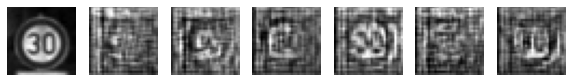

Epoch 781 g_loss= 0.6790848 d_loss= 1.4200873 real_acc= 0.28 fake_acc= 0.3
Epoch 782 g_loss= 0.6862798 d_loss= 1.4278902 real_acc= 0.2 fake_acc= 0.42
Epoch 783 g_loss= 0.68976545 d_loss= 1.4205203 real_acc= 0.32 fake_acc= 0.5
Epoch 784 g_loss= 0.6889265 d_loss= 1.4111184 real_acc= 0.24 fake_acc= 0.42
Epoch 785 g_loss= 0.6889498 d_loss= 1.41527 real_acc= 0.32 fake_acc= 0.42
Epoch 786 g_loss= 0.6874675 d_loss= 1.4037774 real_acc= 0.38 fake_acc= 0.42
Epoch 787 g_loss= 0.67619866 d_loss= 1.4320188 real_acc= 0.34 fake_acc= 0.22
Epoch 788 g_loss= 0.6799887 d_loss= 1.4134389 real_acc= 0.38 fake_acc= 0.32
Epoch 789 g_loss= 0.68178093 d_loss= 1.3957684 real_acc= 0.56 fake_acc= 0.4
Epoch 790 g_loss= 0.6736199 d_loss= 1.3961594 real_acc= 0.62 fake_acc= 0.18


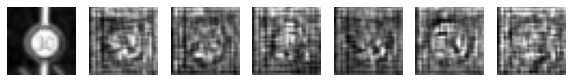

Epoch 791 g_loss= 0.6699088 d_loss= 1.4082644 real_acc= 0.56 fake_acc= 0.16
Epoch 792 g_loss= 0.6672401 d_loss= 1.4152708 real_acc= 0.46 fake_acc= 0.14
Epoch 793 g_loss= 0.6638488 d_loss= 1.4047177 real_acc= 0.64 fake_acc= 0.1
Epoch 794 g_loss= 0.6675613 d_loss= 1.3987968 real_acc= 0.66 fake_acc= 0.12
Epoch 795 g_loss= 0.6631537 d_loss= 1.4128278 real_acc= 0.56 fake_acc= 0.14
Epoch 796 g_loss= 0.66011965 d_loss= 1.3984878 real_acc= 0.62 fake_acc= 0.1
Epoch 797 g_loss= 0.662589 d_loss= 1.3901601 real_acc= 0.8 fake_acc= 0.12
Epoch 798 g_loss= 0.654604 d_loss= 1.4008069 real_acc= 0.76 fake_acc= 0.02
Epoch 799 g_loss= 0.65277255 d_loss= 1.4126084 real_acc= 0.7 fake_acc= 0.04
Epoch 800 g_loss= 0.6504963 d_loss= 1.4039454 real_acc= 0.72 fake_acc= 0.06


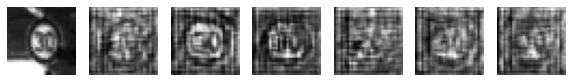

Epoch 801 g_loss= 0.6584007 d_loss= 1.4106455 real_acc= 0.62 fake_acc= 0.1
Epoch 802 g_loss= 0.6547313 d_loss= 1.3952379 real_acc= 0.78 fake_acc= 0.04
Epoch 803 g_loss= 0.6588361 d_loss= 1.395446 real_acc= 0.72 fake_acc= 0.04
Epoch 804 g_loss= 0.6553967 d_loss= 1.3895667 real_acc= 0.74 fake_acc= 0.12
Epoch 805 g_loss= 0.6643544 d_loss= 1.390673 real_acc= 0.68 fake_acc= 0.1
Epoch 806 g_loss= 0.6619794 d_loss= 1.3989743 real_acc= 0.7 fake_acc= 0.1
Epoch 807 g_loss= 0.6707747 d_loss= 1.3995645 real_acc= 0.7 fake_acc= 0.18
Epoch 808 g_loss= 0.6723666 d_loss= 1.3892561 real_acc= 0.74 fake_acc= 0.24
Epoch 809 g_loss= 0.67619586 d_loss= 1.3982906 real_acc= 0.56 fake_acc= 0.24
Epoch 810 g_loss= 0.6798967 d_loss= 1.3896046 real_acc= 0.6 fake_acc= 0.32


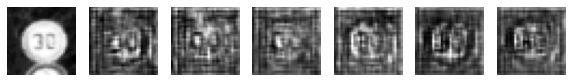

Epoch 811 g_loss= 0.6876517 d_loss= 1.386246 real_acc= 0.48 fake_acc= 0.36
Epoch 812 g_loss= 0.6862921 d_loss= 1.3896557 real_acc= 0.56 fake_acc= 0.38
Epoch 813 g_loss= 0.6861592 d_loss= 1.383766 real_acc= 0.58 fake_acc= 0.44
Epoch 814 g_loss= 0.6935848 d_loss= 1.3899871 real_acc= 0.44 fake_acc= 0.56
Epoch 815 g_loss= 0.6958771 d_loss= 1.3904505 real_acc= 0.38 fake_acc= 0.6
Epoch 816 g_loss= 0.6965818 d_loss= 1.3744173 real_acc= 0.48 fake_acc= 0.54
Epoch 817 g_loss= 0.6907844 d_loss= 1.3795598 real_acc= 0.68 fake_acc= 0.48
Epoch 818 g_loss= 0.68727523 d_loss= 1.3890243 real_acc= 0.42 fake_acc= 0.42
Epoch 819 g_loss= 0.6889927 d_loss= 1.3814218 real_acc= 0.58 fake_acc= 0.48
Epoch 820 g_loss= 0.6943258 d_loss= 1.3794737 real_acc= 0.56 fake_acc= 0.52


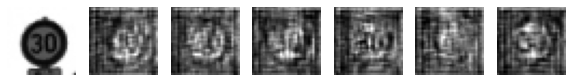

Epoch 821 g_loss= 0.69070536 d_loss= 1.379786 real_acc= 0.58 fake_acc= 0.54
Epoch 822 g_loss= 0.6894314 d_loss= 1.3686951 real_acc= 0.6 fake_acc= 0.5
Epoch 823 g_loss= 0.69727415 d_loss= 1.3823497 real_acc= 0.5 fake_acc= 0.54
Epoch 824 g_loss= 0.6926818 d_loss= 1.4027848 real_acc= 0.36 fake_acc= 0.44
Epoch 825 g_loss= 0.6967453 d_loss= 1.3815749 real_acc= 0.5 fake_acc= 0.52
Epoch 826 g_loss= 0.6970528 d_loss= 1.3889296 real_acc= 0.46 fake_acc= 0.6
Epoch 827 g_loss= 0.6928799 d_loss= 1.3797768 real_acc= 0.5 fake_acc= 0.54
Epoch 828 g_loss= 0.6974116 d_loss= 1.375329 real_acc= 0.58 fake_acc= 0.54
Epoch 829 g_loss= 0.69126284 d_loss= 1.375041 real_acc= 0.56 fake_acc= 0.48
Epoch 830 g_loss= 0.6886076 d_loss= 1.3846436 real_acc= 0.54 fake_acc= 0.44


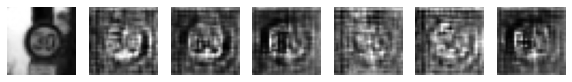

Epoch 831 g_loss= 0.69220155 d_loss= 1.3906343 real_acc= 0.4 fake_acc= 0.48
Epoch 832 g_loss= 0.694542 d_loss= 1.3738678 real_acc= 0.54 fake_acc= 0.52
Epoch 833 g_loss= 0.6981594 d_loss= 1.3656319 real_acc= 0.54 fake_acc= 0.64
Epoch 834 g_loss= 0.6939007 d_loss= 1.3716235 real_acc= 0.62 fake_acc= 0.5
Epoch 835 g_loss= 0.691531 d_loss= 1.3829246 real_acc= 0.64 fake_acc= 0.44
Epoch 836 g_loss= 0.6971901 d_loss= 1.3646859 real_acc= 0.6 fake_acc= 0.68
Epoch 837 g_loss= 0.6943672 d_loss= 1.3676002 real_acc= 0.66 fake_acc= 0.56
Epoch 838 g_loss= 0.6950753 d_loss= 1.3723607 real_acc= 0.62 fake_acc= 0.5
Epoch 839 g_loss= 0.6916438 d_loss= 1.3749137 real_acc= 0.58 fake_acc= 0.52
Epoch 840 g_loss= 0.69868433 d_loss= 1.3596258 real_acc= 0.6 fake_acc= 0.6


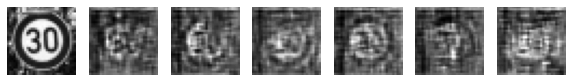

Epoch 841 g_loss= 0.6976302 d_loss= 1.3630484 real_acc= 0.58 fake_acc= 0.6
Epoch 842 g_loss= 0.69233763 d_loss= 1.3939083 real_acc= 0.5 fake_acc= 0.58
Epoch 843 g_loss= 0.7010255 d_loss= 1.3681033 real_acc= 0.6 fake_acc= 0.6
Epoch 844 g_loss= 0.70096433 d_loss= 1.365371 real_acc= 0.68 fake_acc= 0.6
Epoch 845 g_loss= 0.70038736 d_loss= 1.3796676 real_acc= 0.58 fake_acc= 0.64
Epoch 846 g_loss= 0.7001037 d_loss= 1.3792723 real_acc= 0.54 fake_acc= 0.68
Epoch 847 g_loss= 0.698606 d_loss= 1.3769749 real_acc= 0.48 fake_acc= 0.64
Epoch 848 g_loss= 0.701334 d_loss= 1.3672411 real_acc= 0.58 fake_acc= 0.62
Epoch 849 g_loss= 0.7055212 d_loss= 1.3728279 real_acc= 0.48 fake_acc= 0.7
Epoch 850 g_loss= 0.7008229 d_loss= 1.3818586 real_acc= 0.4 fake_acc= 0.56


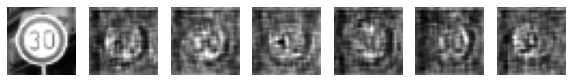

Epoch 851 g_loss= 0.7078416 d_loss= 1.358108 real_acc= 0.58 fake_acc= 0.7
Epoch 852 g_loss= 0.7107711 d_loss= 1.3710849 real_acc= 0.42 fake_acc= 0.78
Epoch 853 g_loss= 0.70549124 d_loss= 1.377375 real_acc= 0.48 fake_acc= 0.72
Epoch 854 g_loss= 0.7054657 d_loss= 1.3736051 real_acc= 0.54 fake_acc= 0.64
Epoch 855 g_loss= 0.7034749 d_loss= 1.3764391 real_acc= 0.54 fake_acc= 0.64
Epoch 856 g_loss= 0.70395255 d_loss= 1.3761915 real_acc= 0.58 fake_acc= 0.68
Epoch 857 g_loss= 0.7018811 d_loss= 1.3739841 real_acc= 0.54 fake_acc= 0.64
Epoch 858 g_loss= 0.6994623 d_loss= 1.3719321 real_acc= 0.62 fake_acc= 0.54
Epoch 859 g_loss= 0.7000869 d_loss= 1.3731976 real_acc= 0.64 fake_acc= 0.6
Epoch 860 g_loss= 0.70272154 d_loss= 1.3773975 real_acc= 0.54 fake_acc= 0.66


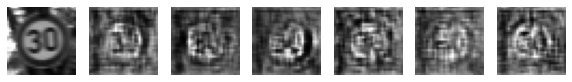

Epoch 861 g_loss= 0.7004631 d_loss= 1.3754859 real_acc= 0.52 fake_acc= 0.54
Epoch 862 g_loss= 0.7009721 d_loss= 1.3784174 real_acc= 0.4 fake_acc= 0.64
Epoch 863 g_loss= 0.696594 d_loss= 1.3850437 real_acc= 0.42 fake_acc= 0.62
Epoch 864 g_loss= 0.69601065 d_loss= 1.3800759 real_acc= 0.56 fake_acc= 0.58
Epoch 865 g_loss= 0.6968428 d_loss= 1.3762345 real_acc= 0.52 fake_acc= 0.56
Epoch 866 g_loss= 0.6940702 d_loss= 1.3564506 real_acc= 0.72 fake_acc= 0.58
Epoch 867 g_loss= 0.69006234 d_loss= 1.3780932 real_acc= 0.58 fake_acc= 0.52
Epoch 868 g_loss= 0.69228333 d_loss= 1.3656797 real_acc= 0.6 fake_acc= 0.46
Epoch 869 g_loss= 0.6938707 d_loss= 1.3743105 real_acc= 0.6 fake_acc= 0.46
Epoch 870 g_loss= 0.68672675 d_loss= 1.3774921 real_acc= 0.66 fake_acc= 0.48


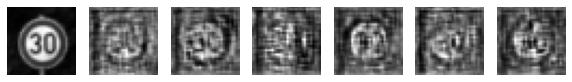

Epoch 871 g_loss= 0.6813034 d_loss= 1.385222 real_acc= 0.64 fake_acc= 0.34
Epoch 872 g_loss= 0.684734 d_loss= 1.3897365 real_acc= 0.58 fake_acc= 0.36
Epoch 873 g_loss= 0.68439573 d_loss= 1.3825336 real_acc= 0.6 fake_acc= 0.36
Epoch 874 g_loss= 0.6872986 d_loss= 1.3677822 real_acc= 0.72 fake_acc= 0.34
Epoch 875 g_loss= 0.6780502 d_loss= 1.3872995 real_acc= 0.68 fake_acc= 0.22
Epoch 876 g_loss= 0.68062216 d_loss= 1.3696327 real_acc= 0.68 fake_acc= 0.26
Epoch 877 g_loss= 0.6745484 d_loss= 1.3828509 real_acc= 0.62 fake_acc= 0.22
Epoch 878 g_loss= 0.67176175 d_loss= 1.3739967 real_acc= 0.72 fake_acc= 0.16
Epoch 879 g_loss= 0.67127156 d_loss= 1.3852985 real_acc= 0.74 fake_acc= 0.22
Epoch 880 g_loss= 0.6743499 d_loss= 1.3766304 real_acc= 0.66 fake_acc= 0.26


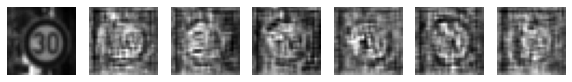

Epoch 881 g_loss= 0.6667954 d_loss= 1.3980763 real_acc= 0.7 fake_acc= 0.1
Epoch 882 g_loss= 0.66726816 d_loss= 1.3841558 real_acc= 0.72 fake_acc= 0.18
Epoch 883 g_loss= 0.6667231 d_loss= 1.3980742 real_acc= 0.68 fake_acc= 0.14
Epoch 884 g_loss= 0.6669859 d_loss= 1.3943422 real_acc= 0.64 fake_acc= 0.1
Epoch 885 g_loss= 0.66115904 d_loss= 1.4005853 real_acc= 0.7 fake_acc= 0.06
Epoch 886 g_loss= 0.661986 d_loss= 1.3801332 real_acc= 0.68 fake_acc= 0.08
Epoch 887 g_loss= 0.66496825 d_loss= 1.3837115 real_acc= 0.7 fake_acc= 0.06
Epoch 888 g_loss= 0.6597464 d_loss= 1.3807634 real_acc= 0.78 fake_acc= 0.04
Epoch 889 g_loss= 0.65382504 d_loss= 1.3929656 real_acc= 0.76 fake_acc= 0.0
Epoch 890 g_loss= 0.6543416 d_loss= 1.3725709 real_acc= 0.84 fake_acc= 0.04


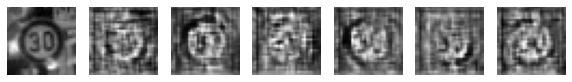

Epoch 891 g_loss= 0.6526723 d_loss= 1.3795907 real_acc= 0.82 fake_acc= 0.08
Epoch 892 g_loss= 0.6545789 d_loss= 1.3724899 real_acc= 0.8 fake_acc= 0.02
Epoch 893 g_loss= 0.65256935 d_loss= 1.3915625 real_acc= 0.78 fake_acc= 0.04
Epoch 894 g_loss= 0.6560876 d_loss= 1.3973045 real_acc= 0.7 fake_acc= 0.06
Epoch 895 g_loss= 0.6514985 d_loss= 1.396582 real_acc= 0.8 fake_acc= 0.06
Epoch 896 g_loss= 0.65455335 d_loss= 1.3950615 real_acc= 0.62 fake_acc= 0.06
Epoch 897 g_loss= 0.6532088 d_loss= 1.3874675 real_acc= 0.84 fake_acc= 0.0
Epoch 898 g_loss= 0.65612185 d_loss= 1.3934338 real_acc= 0.72 fake_acc= 0.08
Epoch 899 g_loss= 0.65459764 d_loss= 1.3958148 real_acc= 0.74 fake_acc= 0.06
Epoch 900 g_loss= 0.6563551 d_loss= 1.3838868 real_acc= 0.78 fake_acc= 0.08


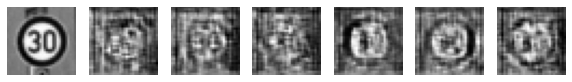

Epoch 901 g_loss= 0.6548967 d_loss= 1.4025869 real_acc= 0.72 fake_acc= 0.08
Epoch 902 g_loss= 0.6618892 d_loss= 1.3769493 real_acc= 0.76 fake_acc= 0.16
Epoch 903 g_loss= 0.6581147 d_loss= 1.4031186 real_acc= 0.66 fake_acc= 0.1
Epoch 904 g_loss= 0.66046506 d_loss= 1.3910244 real_acc= 0.74 fake_acc= 0.1
Epoch 905 g_loss= 0.6633361 d_loss= 1.3903174 real_acc= 0.76 fake_acc= 0.16
Epoch 906 g_loss= 0.6669374 d_loss= 1.394244 real_acc= 0.62 fake_acc= 0.16
Epoch 907 g_loss= 0.66534483 d_loss= 1.388756 real_acc= 0.6 fake_acc= 0.08
Epoch 908 g_loss= 0.66401345 d_loss= 1.3780291 real_acc= 0.8 fake_acc= 0.16
Epoch 909 g_loss= 0.663702 d_loss= 1.381563 real_acc= 0.76 fake_acc= 0.04
Epoch 910 g_loss= 0.66557175 d_loss= 1.3779215 real_acc= 0.88 fake_acc= 0.16


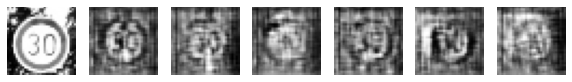

Epoch 911 g_loss= 0.65914065 d_loss= 1.3937975 real_acc= 0.66 fake_acc= 0.08
Epoch 912 g_loss= 0.66746634 d_loss= 1.3846085 real_acc= 0.74 fake_acc= 0.14
Epoch 913 g_loss= 0.663163 d_loss= 1.3838023 real_acc= 0.72 fake_acc= 0.14
Epoch 914 g_loss= 0.66609496 d_loss= 1.381149 real_acc= 0.72 fake_acc= 0.16
Epoch 915 g_loss= 0.6659681 d_loss= 1.3826146 real_acc= 0.78 fake_acc= 0.18
Epoch 916 g_loss= 0.65914655 d_loss= 1.3915288 real_acc= 0.74 fake_acc= 0.1
Epoch 917 g_loss= 0.65870935 d_loss= 1.3850877 real_acc= 0.74 fake_acc= 0.04
Epoch 918 g_loss= 0.6602055 d_loss= 1.3929386 real_acc= 0.68 fake_acc= 0.06
Epoch 919 g_loss= 0.6682827 d_loss= 1.388392 real_acc= 0.74 fake_acc= 0.2
Epoch 920 g_loss= 0.663781 d_loss= 1.378262 real_acc= 0.68 fake_acc= 0.1


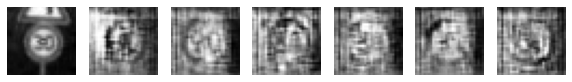

Epoch 921 g_loss= 0.6633146 d_loss= 1.3833439 real_acc= 0.76 fake_acc= 0.1
Epoch 922 g_loss= 0.6596605 d_loss= 1.3768284 real_acc= 0.86 fake_acc= 0.04
Epoch 923 g_loss= 0.66670096 d_loss= 1.3703496 real_acc= 0.86 fake_acc= 0.14
Epoch 924 g_loss= 0.6697512 d_loss= 1.3521614 real_acc= 0.84 fake_acc= 0.18
Epoch 925 g_loss= 0.6634544 d_loss= 1.3893216 real_acc= 0.68 fake_acc= 0.12
Epoch 926 g_loss= 0.66929823 d_loss= 1.3700231 real_acc= 0.86 fake_acc= 0.18
Epoch 927 g_loss= 0.67244935 d_loss= 1.3783545 real_acc= 0.74 fake_acc= 0.18
Epoch 928 g_loss= 0.66683793 d_loss= 1.3782148 real_acc= 0.78 fake_acc= 0.1
Epoch 929 g_loss= 0.67262137 d_loss= 1.3645139 real_acc= 0.82 fake_acc= 0.24
Epoch 930 g_loss= 0.66845816 d_loss= 1.371869 real_acc= 0.86 fake_acc= 0.2


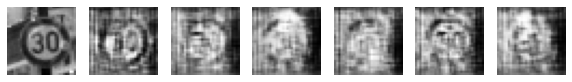

Epoch 931 g_loss= 0.67184675 d_loss= 1.3704107 real_acc= 0.86 fake_acc= 0.16
Epoch 932 g_loss= 0.67682683 d_loss= 1.3611406 real_acc= 0.76 fake_acc= 0.3
Epoch 933 g_loss= 0.67526853 d_loss= 1.371859 real_acc= 0.84 fake_acc= 0.24
Epoch 934 g_loss= 0.67332435 d_loss= 1.3640993 real_acc= 0.82 fake_acc= 0.24
Epoch 935 g_loss= 0.6790196 d_loss= 1.3702753 real_acc= 0.74 fake_acc= 0.3
Epoch 936 g_loss= 0.6800669 d_loss= 1.3560016 real_acc= 0.76 fake_acc= 0.24
Epoch 937 g_loss= 0.68476546 d_loss= 1.3548021 real_acc= 0.86 fake_acc= 0.34
Epoch 938 g_loss= 0.6841987 d_loss= 1.363457 real_acc= 0.76 fake_acc= 0.3
Epoch 939 g_loss= 0.6901355 d_loss= 1.3550935 real_acc= 0.7 fake_acc= 0.46
Epoch 940 g_loss= 0.6898425 d_loss= 1.3592286 real_acc= 0.76 fake_acc= 0.54


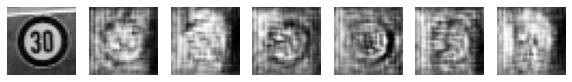

Epoch 941 g_loss= 0.69306684 d_loss= 1.3503277 real_acc= 0.78 fake_acc= 0.42
Epoch 942 g_loss= 0.696959 d_loss= 1.3447423 real_acc= 0.68 fake_acc= 0.54
Epoch 943 g_loss= 0.70193094 d_loss= 1.3567176 real_acc= 0.68 fake_acc= 0.62
Epoch 944 g_loss= 0.70464563 d_loss= 1.3350105 real_acc= 0.76 fake_acc= 0.68
Epoch 945 g_loss= 0.69620997 d_loss= 1.3618468 real_acc= 0.76 fake_acc= 0.56
Epoch 946 g_loss= 0.7031629 d_loss= 1.3421628 real_acc= 0.7 fake_acc= 0.68
Epoch 947 g_loss= 0.7034795 d_loss= 1.339597 real_acc= 0.8 fake_acc= 0.66
Epoch 948 g_loss= 0.7011918 d_loss= 1.3387207 real_acc= 0.72 fake_acc= 0.62
Epoch 949 g_loss= 0.70362335 d_loss= 1.319575 real_acc= 0.82 fake_acc= 0.7
Epoch 950 g_loss= 0.70875496 d_loss= 1.3487811 real_acc= 0.7 fake_acc= 0.72


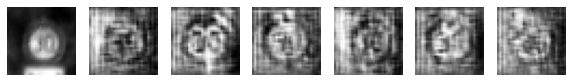

Epoch 951 g_loss= 0.71376914 d_loss= 1.318943 real_acc= 0.78 fake_acc= 0.72
Epoch 952 g_loss= 0.7137909 d_loss= 1.3391004 real_acc= 0.72 fake_acc= 0.8
Epoch 953 g_loss= 0.70945275 d_loss= 1.3400761 real_acc= 0.66 fake_acc= 0.76
Epoch 954 g_loss= 0.7147893 d_loss= 1.325243 real_acc= 0.68 fake_acc= 0.82
Epoch 955 g_loss= 0.7151335 d_loss= 1.3480442 real_acc= 0.6 fake_acc= 0.76
Epoch 956 g_loss= 0.7154018 d_loss= 1.3467345 real_acc= 0.56 fake_acc= 0.74
Epoch 957 g_loss= 0.71266 d_loss= 1.3437123 real_acc= 0.64 fake_acc= 0.7
Epoch 958 g_loss= 0.71786726 d_loss= 1.3382597 real_acc= 0.72 fake_acc= 0.8
Epoch 959 g_loss= 0.723957 d_loss= 1.3455251 real_acc= 0.54 fake_acc= 0.9
Epoch 960 g_loss= 0.72637415 d_loss= 1.3319528 real_acc= 0.66 fake_acc= 0.86


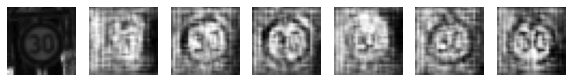

Epoch 961 g_loss= 0.72107637 d_loss= 1.343205 real_acc= 0.64 fake_acc= 0.76
Epoch 962 g_loss= 0.72219104 d_loss= 1.3448255 real_acc= 0.62 fake_acc= 0.78
Epoch 963 g_loss= 0.7174075 d_loss= 1.3451653 real_acc= 0.68 fake_acc= 0.78
Epoch 964 g_loss= 0.7238429 d_loss= 1.3265386 real_acc= 0.68 fake_acc= 0.84
Epoch 965 g_loss= 0.7270801 d_loss= 1.3365647 real_acc= 0.58 fake_acc= 0.84
Epoch 966 g_loss= 0.7236626 d_loss= 1.3362854 real_acc= 0.66 fake_acc= 0.84
Epoch 967 g_loss= 0.72941726 d_loss= 1.3186779 real_acc= 0.76 fake_acc= 0.84
Epoch 968 g_loss= 0.7270497 d_loss= 1.3360004 real_acc= 0.62 fake_acc= 0.92
Epoch 969 g_loss= 0.7201971 d_loss= 1.3302348 real_acc= 0.74 fake_acc= 0.7
Epoch 970 g_loss= 0.7178738 d_loss= 1.343548 real_acc= 0.72 fake_acc= 0.7


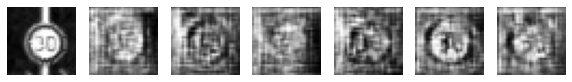

Epoch 971 g_loss= 0.70905596 d_loss= 1.3522127 real_acc= 0.68 fake_acc= 0.72
Epoch 972 g_loss= 0.7109471 d_loss= 1.342246 real_acc= 0.74 fake_acc= 0.68
Epoch 973 g_loss= 0.71061444 d_loss= 1.3232484 real_acc= 0.82 fake_acc= 0.68
Epoch 974 g_loss= 0.70842963 d_loss= 1.3225282 real_acc= 0.86 fake_acc= 0.68
Epoch 975 g_loss= 0.6935634 d_loss= 1.3459699 real_acc= 0.8 fake_acc= 0.54
Epoch 976 g_loss= 0.6958989 d_loss= 1.3374028 real_acc= 0.84 fake_acc= 0.46
Epoch 977 g_loss= 0.6955877 d_loss= 1.3522785 real_acc= 0.76 fake_acc= 0.48
Epoch 978 g_loss= 0.701399 d_loss= 1.3318812 real_acc= 0.8 fake_acc= 0.52
Epoch 979 g_loss= 0.70475745 d_loss= 1.3464167 real_acc= 0.62 fake_acc= 0.6
Epoch 980 g_loss= 0.7033239 d_loss= 1.3425972 real_acc= 0.74 fake_acc= 0.54


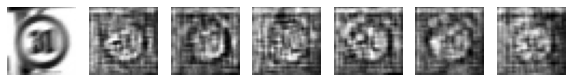

Epoch 981 g_loss= 0.7103934 d_loss= 1.3498423 real_acc= 0.78 fake_acc= 0.72
Epoch 982 g_loss= 0.7107337 d_loss= 1.3658528 real_acc= 0.56 fake_acc= 0.66
Epoch 983 g_loss= 0.7112639 d_loss= 1.353071 real_acc= 0.64 fake_acc= 0.74
Epoch 984 g_loss= 0.71324176 d_loss= 1.3660522 real_acc= 0.48 fake_acc= 0.68
Epoch 985 g_loss= 0.7069203 d_loss= 1.3587081 real_acc= 0.56 fake_acc= 0.62
Epoch 986 g_loss= 0.7080446 d_loss= 1.3684144 real_acc= 0.54 fake_acc= 0.64
Epoch 987 g_loss= 0.7135506 d_loss= 1.3581961 real_acc= 0.64 fake_acc= 0.62
Epoch 988 g_loss= 0.7052293 d_loss= 1.3710272 real_acc= 0.42 fake_acc= 0.6
Epoch 989 g_loss= 0.7122151 d_loss= 1.3615041 real_acc= 0.54 fake_acc= 0.68
Epoch 990 g_loss= 0.7033193 d_loss= 1.3644388 real_acc= 0.52 fake_acc= 0.6


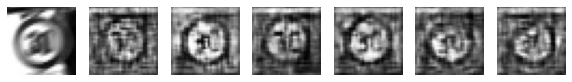

Epoch 991 g_loss= 0.7065983 d_loss= 1.3810713 real_acc= 0.4 fake_acc= 0.54
Epoch 992 g_loss= 0.70490164 d_loss= 1.3692827 real_acc= 0.52 fake_acc= 0.62
Epoch 993 g_loss= 0.698057 d_loss= 1.3830433 real_acc= 0.42 fake_acc= 0.52
Epoch 994 g_loss= 0.69543755 d_loss= 1.3984596 real_acc= 0.3 fake_acc= 0.52
Epoch 995 g_loss= 0.6960598 d_loss= 1.3959646 real_acc= 0.36 fake_acc= 0.56
Epoch 996 g_loss= 0.6948957 d_loss= 1.3957751 real_acc= 0.42 fake_acc= 0.52
Epoch 997 g_loss= 0.6986406 d_loss= 1.4033679 real_acc= 0.32 fake_acc= 0.44
Epoch 998 g_loss= 0.69919306 d_loss= 1.3919275 real_acc= 0.38 fake_acc= 0.52
Epoch 999 g_loss= 0.69199926 d_loss= 1.4019343 real_acc= 0.46 fake_acc= 0.56
Done


In [19]:
epochs = 1000
for epoch in range(epochs):
    # take some random samples
    new_samples = sample_from_dataset(50,samples)
    # perform one training step (epoch)
    do_step(new_samples)
    
    if epoch % 10 == 0:
        # show one real image and some fake images generated by generator using noise seed
        #display.clear_output(wait=True)
        num_examples_to_generate = 6
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        predictions = generator(seed, training=False)
        fig = plt.figure(figsize=(10,10))
        r = random.randrange(len(samples))
        plt.subplot(1, num_examples_to_generate+1, 1)
        plt.imshow(samples[r, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        for i in range(predictions.shape[0]):
            plt.subplot(1, num_examples_to_generate+1, i+2)
            #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()    
print("Done")

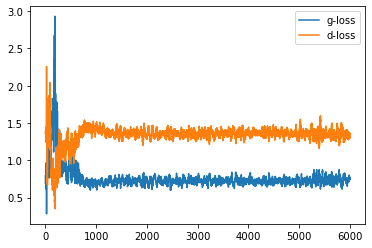

In [33]:
nph = np.array(history)

plt.plot(nph[:,0], label='g-loss')
plt.plot(nph[:,1], label='d-loss')
plt.legend()
plt.show()

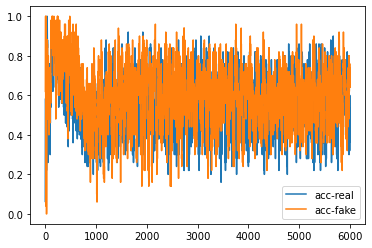

In [40]:
nph = np.array(history)

plt.plot(nph[:,2], label='acc-real')
plt.plot(nph[:,3], label='acc-fake')
plt.legend()
plt.show()

In [38]:
generator.save_weights('generator2_6000_weights')